In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 15.5,
                     'axes.titlepad': 25,
                     'axes.labelpad': 20,
                     'axes.labelsize': 20,
                     'xtick.labelsize' : 15.5,
                     'ytick.labelsize' : 15.5,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 5,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 100.0,
                     'figure.figsize': [8, 5],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.major.size': 8,
                     'ytick.minor.size': 4,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "43 wt.% PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[0, 1, 0, 1],
     [0, 1, 0, 1],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["30-2"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[5.0588e+02, 5174.770, 9492.830, 14695.640],
             [0, 5.9944e+03, 1.1229e+04, 1.8612e+04],
             [0, 709+8460, 6469+8460, 6867+8460, 12698+8460]]
DT = [[0], [0, 18900, 19080], [0, 8460]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI43/"
results_folder = "results43"
FILES = [["12-18_M2_TBD039_PEI43_70C_NCNC.TXT"],
         ["12-19_M3_TBD039_PEI43_50C_NCN.TXT", "12-19_M4_TBD039_PEI43_50C_C_zwischensweep.TXT", "12-19_M5_TBD039_PEI43_50C_C.TXT"],
         ["12-20_M3_TBD039_PEI43_30C_N-20min.TXT", "12-20_M4_TBD039_PEI43_30C_20min-nCCN.TXT"]]
DATA = [[],[],[]]

for m, files in enumerate(FILES) :
    for i, file in enumerate(files) :
        data_ = np.genfromtxt(folder+file, delimiter='\t', skip_header=4)
        data_[:,-1] = (data_[:,-1] + DT[m][i])
        if not i :
            after = data_[:,-1] >= GASCHANGE[m][0]
            data = data_[after]
        else :
            data = np.append(data[:], data_[:], axis=0)

     # add final time to GASCHANGE, needed in main and make time unit hours
    GASCHANGE[m].append(data[-1,-1])
    GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
    data[:,-1] = data[:,-1] / 60.
    DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    # set initial time to 0 or to time of first full spectrum
    initial_test_t = 0
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]

        er_int_k = np.interp(t_test_set, t_k, er_k, left=np.nan, right=np.nan)
        ei_int_k = np.interp(t_test_set, t_k, ei_k, left=np.nan, right=np.nan)
        
        er_int.append(er_int_k)
        ei_int.append(ei_int_k)

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# don't forget to change the individual terms in the plot function if fitfunction is edited

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon$", "$\\alpha$", "$\\omega_p$ [rad/s]", 
            "$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [rad/s]"]

# starting initial guess for every run
p0_start = np.array([
    # 70
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 50
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 30
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5]])

# boundaries
i_ = np.inf
wi1, wf1 = 0.0, 1.0
wi2, wf2 = 1.0, 4e4
wi3, wf3 = 4e4, 1e7
bounds = ([0.0, 0.0, wi1, 0.0, 0.0, wi3], [i_, 1.0, wf2, i_, 1.0, wf3])

# functions
def der_real (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2), 
            imag(x, de, a, wp, de_2, a_2, wp_2))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    # calculate the individual terms (set right parameter positions and functions)
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:])
    # plot the terms
    ax1.plot(w_, x1_, linestyle=':', color='black')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    # label with a number
    ax1.text(max(1,popt[2]), 1, "(i)", color='black')
    ax1.text(popt[5], max(popt[3]/16, 1e-2), "(iii)", color='blue')


In [5]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(10), np.log(1e9), 1000)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        y = np.exp(der_real(lnw_area, *popt))
        a = np.trapezoid(y, lnw_area)
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            y = np.exp(der_real(lnw_area, *popt))
            a = np.trapezoid(y, lnw_area)
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

title_text = "BDS of  "

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
    ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
    ax1.set_ylabel("$\\log_{10}\\left(~~\\epsilon'_{der} ~~\\right)$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])
    ax2.set_ylabel("$\\log_{10}\\left(~~\\epsilon'' ~~\\right)$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = title_text + SAMPLE_SHORT +'-'+ id + "  at  " + timestr
    plt.title(title)
    ax1.set_xlabel("$\\log_{10}\\left(~~\\omega~ [rad/s] ~~\\right)$")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.87))
    #plt.savefig(results_folder + "/fits/"+id+'-'+str(np.round(dt))+"min.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_17414/833274239.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')


fit score 22822.0
fit parameters [6184000.0, 0.7135, 1.753e-06, 3.488, 0.5865, 64260.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


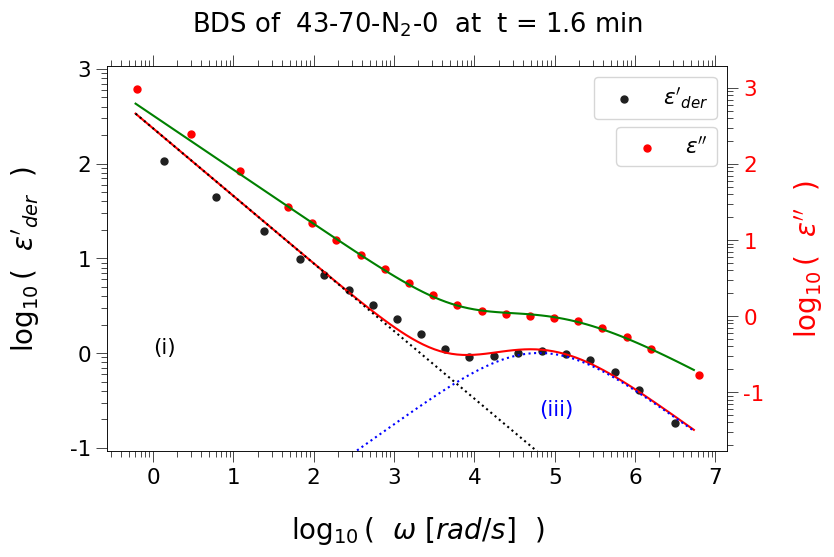

FALLBACK 1:  24849.0
fit score 25742.0
fit parameters [7091000.0, 0.7192, 1.775e-06, 3.507, 0.5858, 65470.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


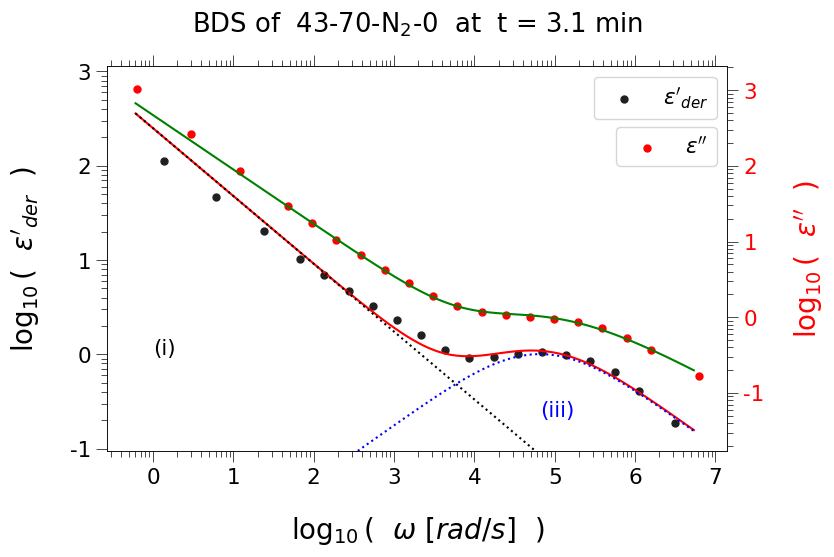

FALLBACK 1:  35116.0
FALLBACK 1:  35571.0
FALLBACK 1:  34414.0
fit score 34414.0
fit parameters [12030000.0, 0.7399, 1.846e-06, 3.54, 0.5888, 73360.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


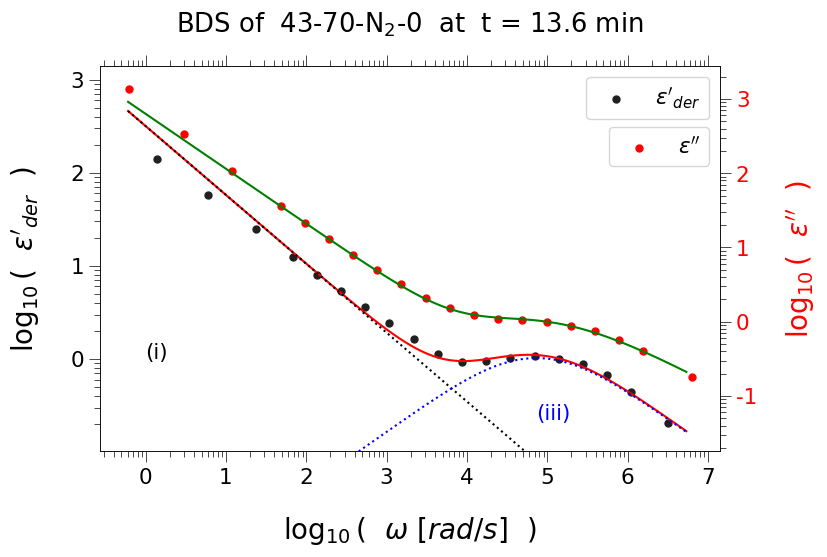

FALLBACK 1:  32622.0
FALLBACK 1:  31681.0
FALLBACK 1:  32963.0
FALLBACK 1:  36669.0
FALLBACK 1:  39202.0
FALLBACK 1:  42033.0
FALLBACK 1:  43629.0
FALLBACK 1:  41589.0
FALLBACK 1:  40921.0
FALLBACK 1:  43829.0
FALLBACK 1:  47400.0
FALLBACK 1:  47207.0
FALLBACK 1:  43743.0
FALLBACK 1:  45813.0
FALLBACK 1:  48428.0
FALLBACK 1:  48146.0
FALLBACK 1:  47460.0
FALLBACK 1:  48028.0
FALLBACK 1:  48946.0
FALLBACK 1:  49888.0
FALLBACK 1:  47493.0
FALLBACK 1:  48384.0
FALLBACK 1:  48484.0
FALLBACK 1:  49072.0
fit score 62578.0
fit parameters [22240000.0, 0.7583, 1.739e-06, 3.545, 0.5934, 88420.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


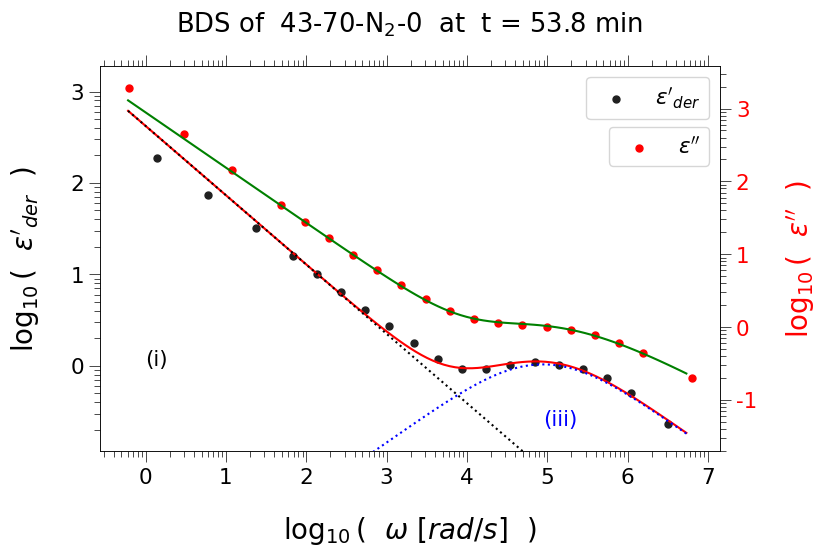

fit score 66699.0
fit parameters [24240000.0, 0.7615, 1.75e-06, 3.55, 0.5929, 91070.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


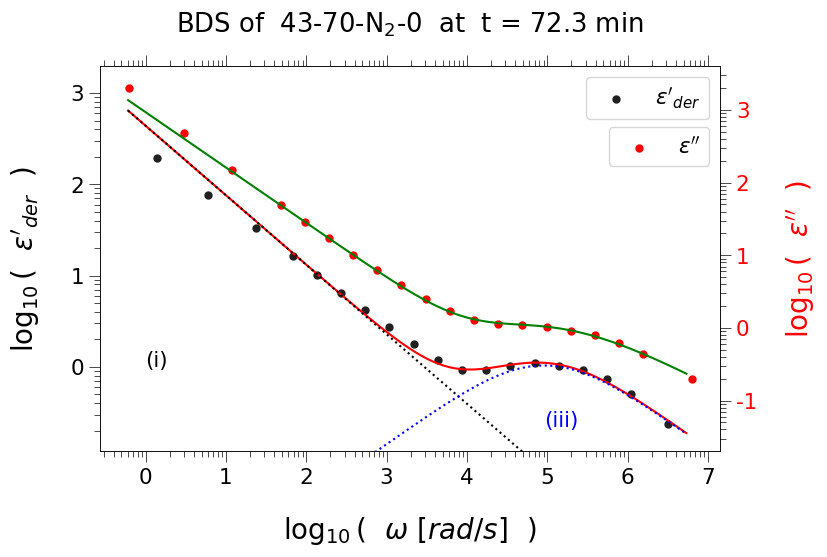

fit score 70458.0
fit parameters [27220000.0, 0.7726, 1.446e-06, 3.49, 0.5669, 72740.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


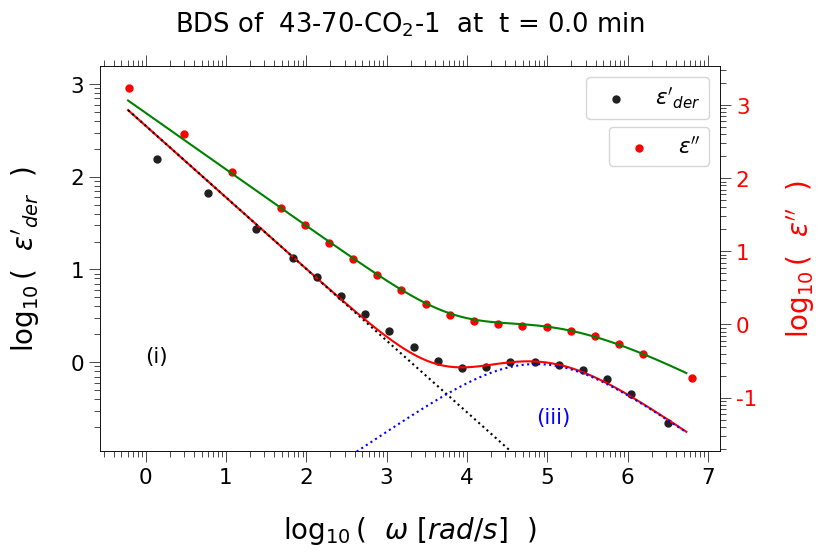

fit score 136317.0
fit parameters [15650000.0, 0.7561, 8.308e-07, 3.52, 0.5375, 53100.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


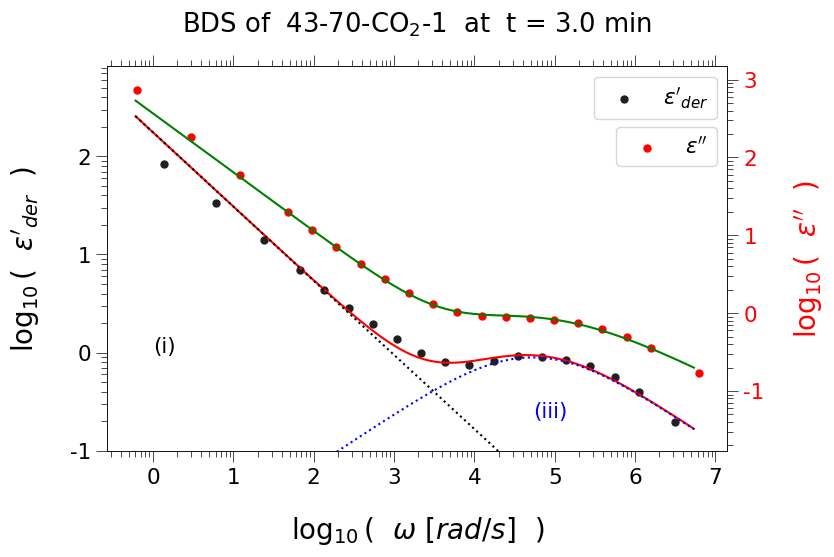

fit score 143174.0
fit parameters [7972000.0, 0.7376, 8.426e-07, 3.535, 0.5101, 45500.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


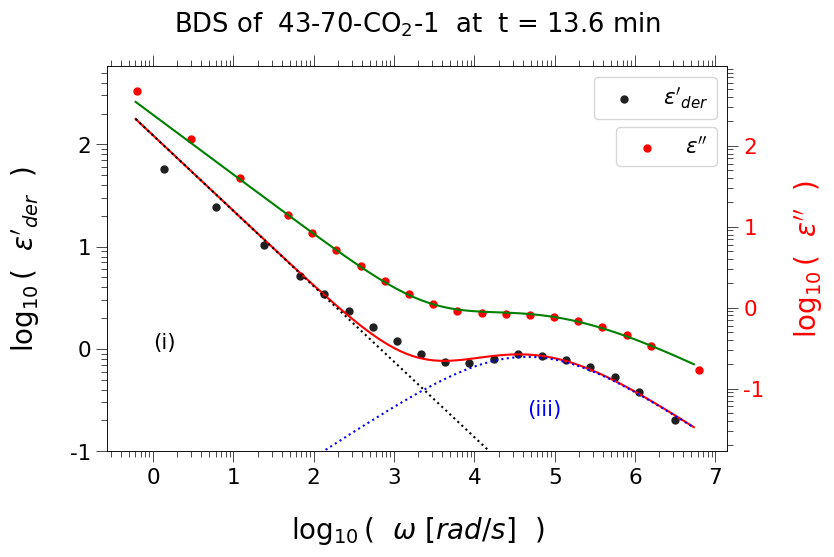

fit score 449000.0
fit parameters [7611000.0, 0.77, 2.178e-06, 3.624, 0.4841, 46920.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


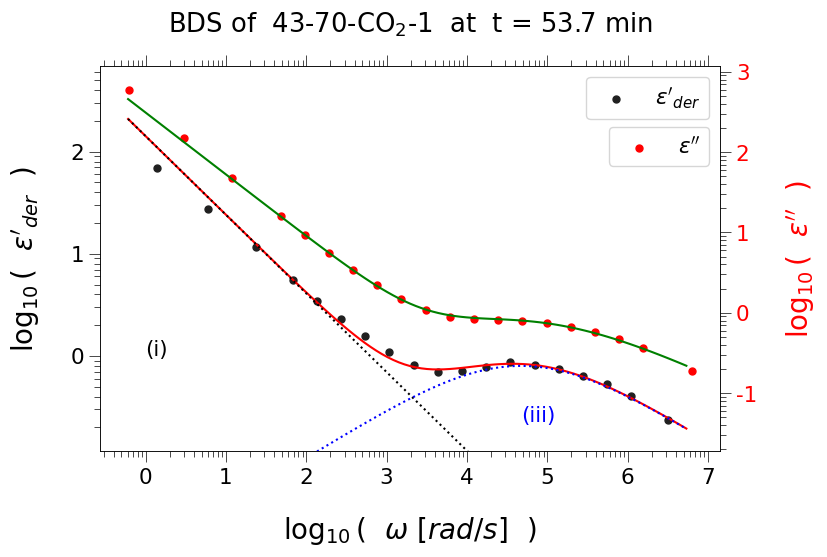

fit score 589993.0
fit parameters [8304000.0, 0.7757, 2.225e-06, 3.638, 0.4797, 46650.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


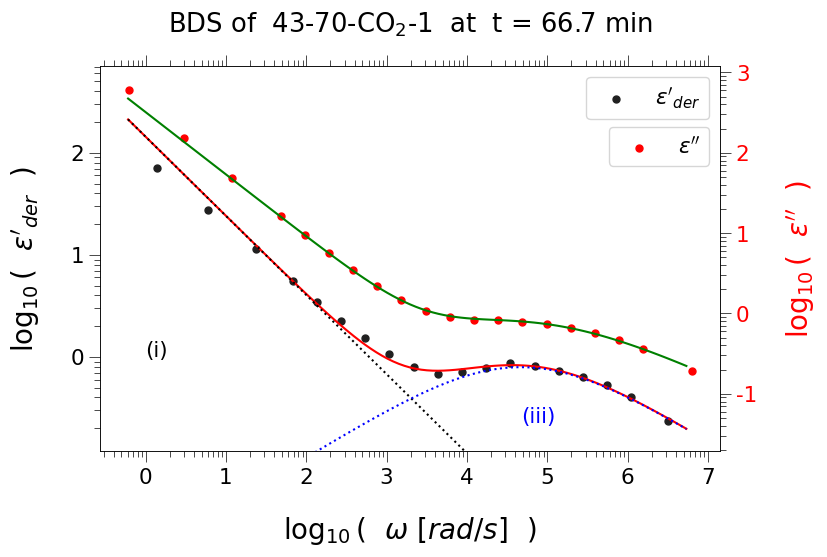

fit score 914201.0
fit parameters [8210000.0, 0.7805, 2.416e-06, 3.678, 0.4756, 44970.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


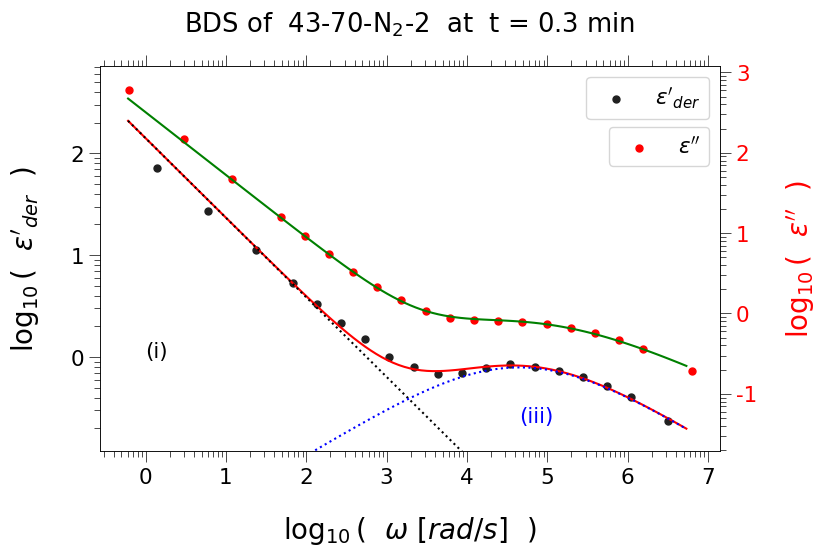

fit score 436315.0
fit parameters [5243000.0, 0.7679, 3.516e-06, 3.819, 0.483, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


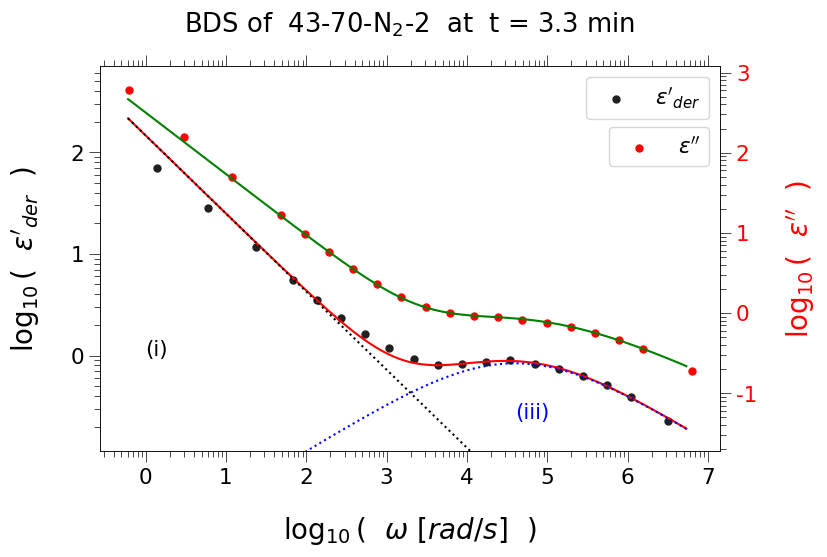

fit score 136333.0
fit parameters [11610000.0, 0.7464, 1.365e-06, 4.009, 0.4978, 43060.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


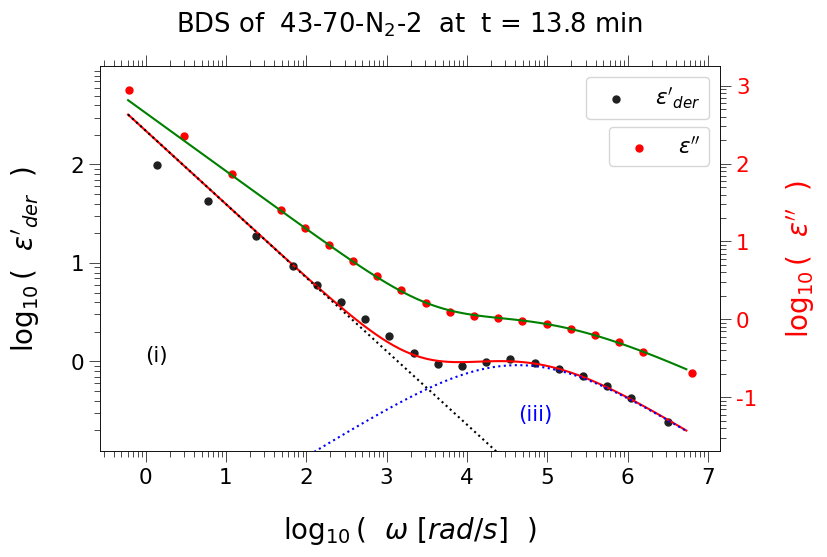

FALLBACK 1:  47931.0
FALLBACK 1:  46038.0
FALLBACK 1:  44310.0
FALLBACK 1:  34833.0
FALLBACK 1:  33512.0
FALLBACK 1:  32787.0
FALLBACK 1:  36040.0
FALLBACK 1:  39343.0
FALLBACK 1:  42842.0
FALLBACK 1:  38733.0
FALLBACK 1:  34773.0
FALLBACK 1:  31164.0
FALLBACK 1:  30279.0
FALLBACK 1:  30424.0
FALLBACK 1:  34912.0
FALLBACK 1:  38289.0
FALLBACK 1:  35596.0
FALLBACK 1:  33893.0
FALLBACK 1:  36789.0
FALLBACK 1:  35580.0
FALLBACK 1:  33354.0
FALLBACK 1:  30551.0
FALLBACK 1:  28679.0
FALLBACK 1:  33547.0
FALLBACK 1:  32389.0
FALLBACK 1:  31164.0
FALLBACK 1:  29492.0
FALLBACK 1:  28309.0
FALLBACK 1:  28206.0
FALLBACK 1:  28071.0
fit score 28071.0
fit parameters [19850000.0, 0.7499, 1.458e-06, 4.022, 0.5093, 73720.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


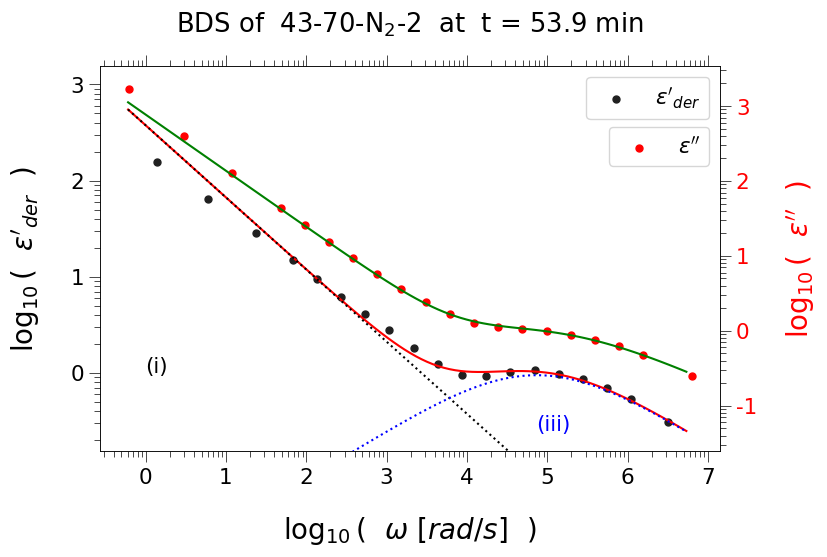

FALLBACK 1:  27409.0
FALLBACK 1:  30941.0
FALLBACK 1:  31340.0
FALLBACK 1:  27202.0
FALLBACK 1:  30043.0
FALLBACK 1:  33374.0
FALLBACK 1:  33790.0
FALLBACK 1:  32135.0
FALLBACK 1:  30801.0
FALLBACK 1:  33191.0
FALLBACK 1:  34916.0
FALLBACK 1:  33837.0
FALLBACK 1:  32586.0
FALLBACK 1:  31955.0
FALLBACK 1:  35440.0
FALLBACK 1:  34492.0
FALLBACK 1:  26830.0
FALLBACK 1:  32086.0
FALLBACK 1:  29232.0
FALLBACK 1:  26393.0
FALLBACK 1:  24031.0
FALLBACK 1:  24805.0
FALLBACK 1:  26182.0
FALLBACK 1:  27518.0
FALLBACK 1:  27430.0
FALLBACK 1:  30156.0
FALLBACK 1:  32134.0
FALLBACK 1:  31692.0
FALLBACK 1:  26155.0
FALLBACK 1:  30608.0
FALLBACK 1:  30123.0
fit score 30123.0
fit parameters [21970000.0, 0.7544, 1.592e-06, 4.017, 0.5109, 81120.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


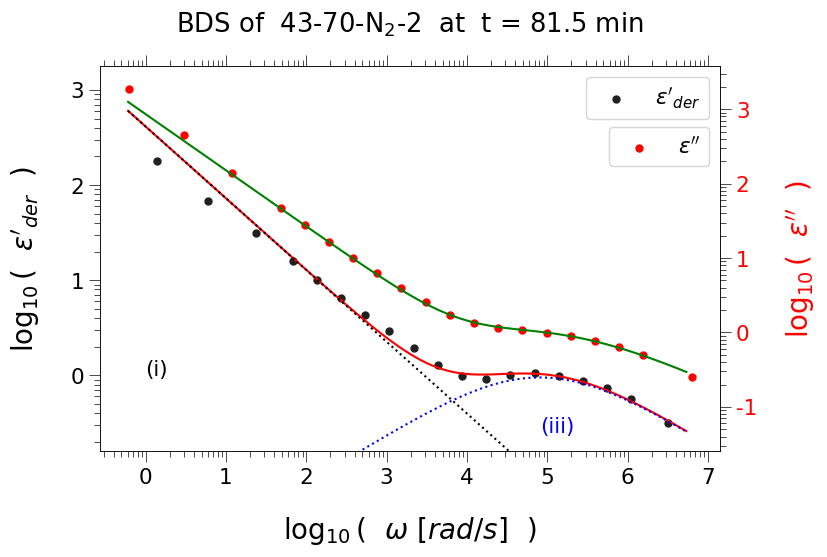

fit score 179817.0
fit parameters [29180000.0, 0.7868, 1.53e-06, 3.878, 0.4917, 58400.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


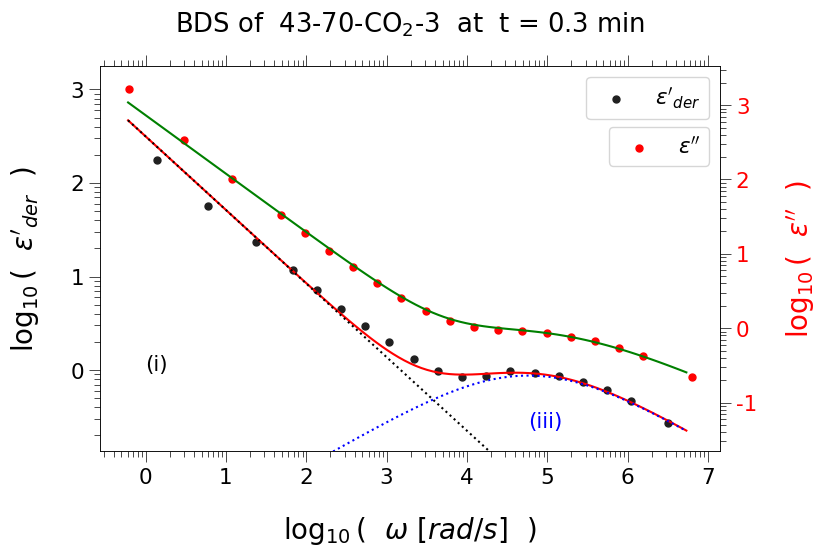

fit score 239128.0
fit parameters [18100000.0, 0.7697, 9.58e-07, 3.8, 0.4845, 50630.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


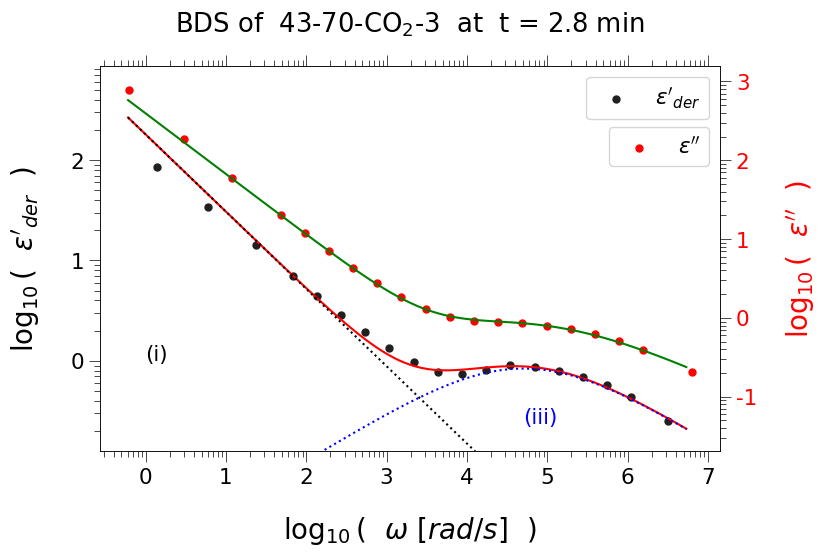

fit score 378120.0
fit parameters [11510000.0, 0.7667, 1.148e-06, 3.759, 0.4703, 43710.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


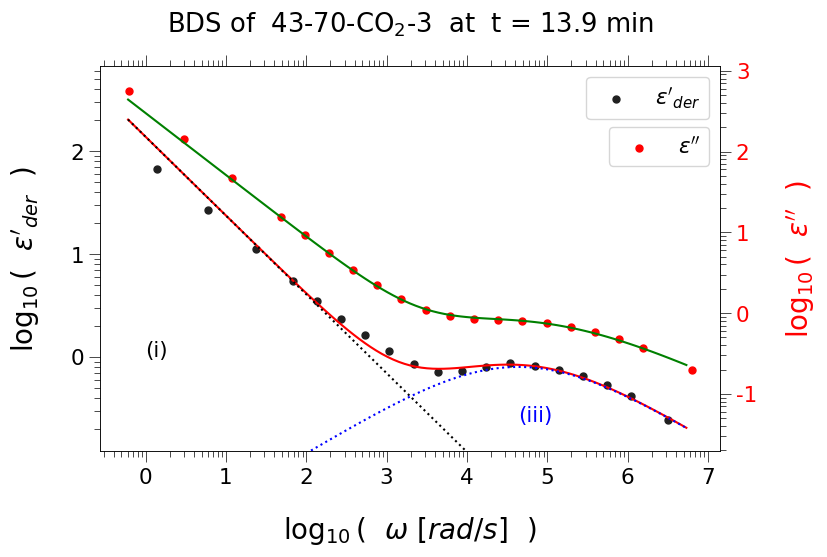

fit score 708041.0
fit parameters [9607000.0, 0.7747, 1.626e-06, 3.747, 0.4637, 41990.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


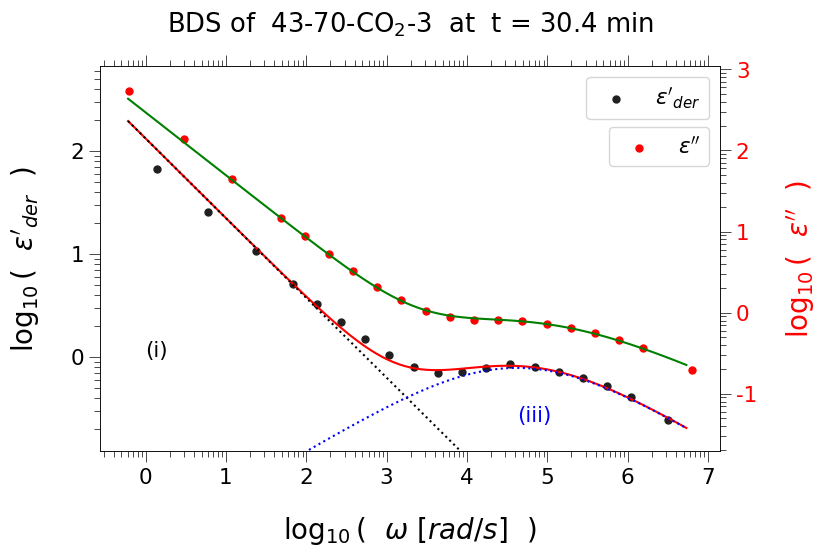

[2.0, 0.7, 0.01, 0.1, 0.5, 400000.0]
0 0 IndexError :  index 0 is out of bounds for axis 0 with size 0
FALLBACK 1:  10858.0
FALLBACK 1:  11960.0
FALLBACK 1:  12201.0
FALLBACK 1:  14244.0
FALLBACK 1:  17404.0
fit score 17404.0
fit parameters [667200.0, 0.6352, 2.001e-06, 3.897, 0.5149, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


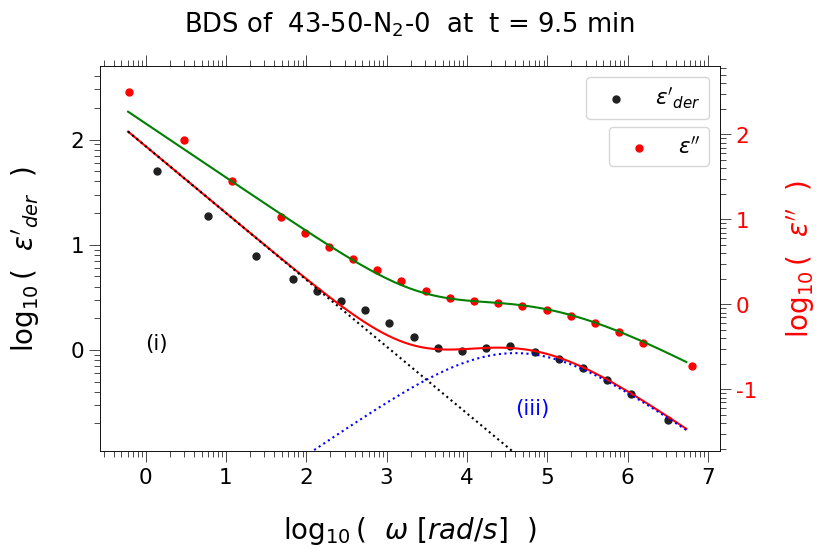

fit score 17817.0
fit parameters [697300.0, 0.6365, 1.974e-06, 3.914, 0.5139, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


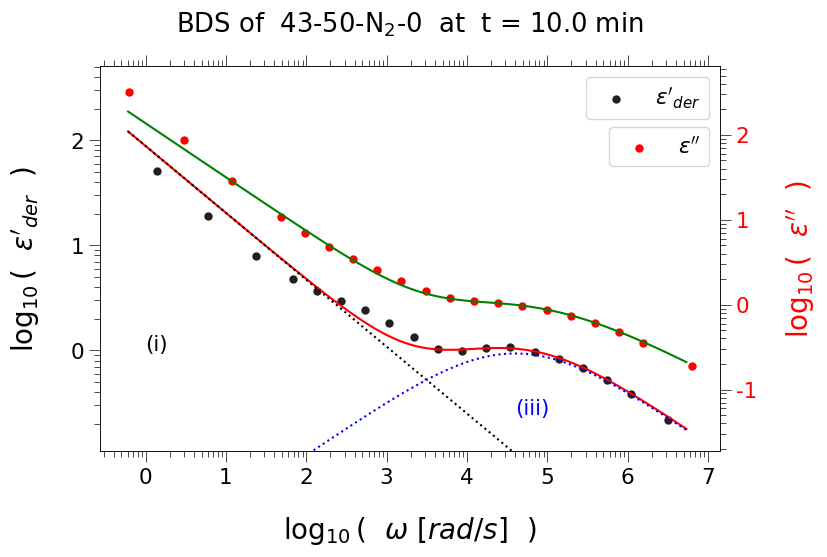

FALLBACK 1:  21174.0
FALLBACK 1:  22128.0
fit score 23224.0
fit parameters [878800.0, 0.6457, 2.053e-06, 4.023, 0.5071, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


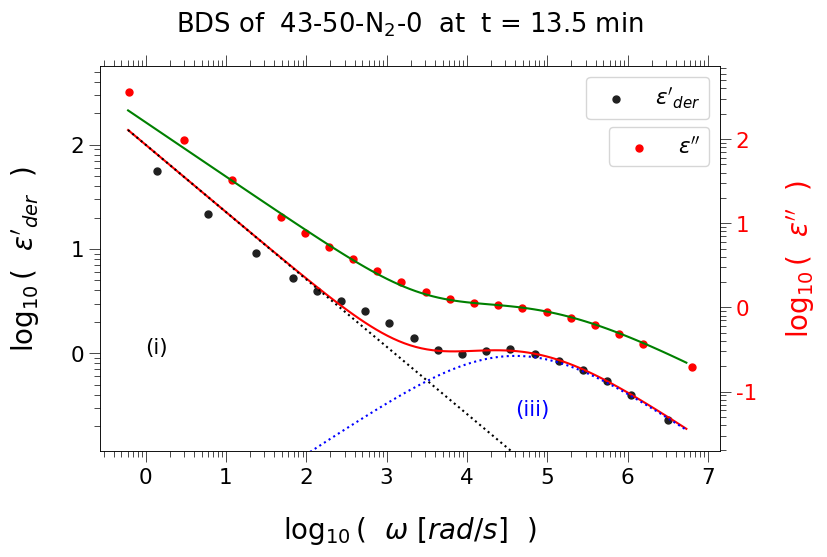

FALLBACK 1:  24340.0
FALLBACK 1:  25583.0
FALLBACK 1:  29417.0
FALLBACK 1:  40185.0
FALLBACK 1:  41553.0
FALLBACK 1:  42817.0
FALLBACK 1:  43430.0
FALLBACK 1:  44745.0
FALLBACK 1:  46280.0
FALLBACK 1:  47704.0
FALLBACK 1:  49633.0
fit score 152470.0
fit parameters [3597000.0, 0.6993, 2.519e-06, 4.654, 0.4712, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


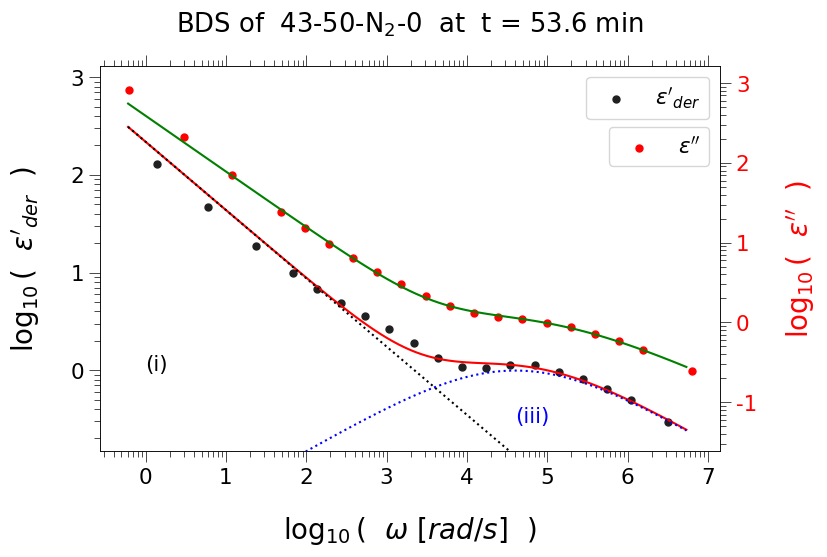

fit score 294631.0
fit parameters [6063000.0, 0.7123, 2.048e-06, 4.821, 0.4604, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


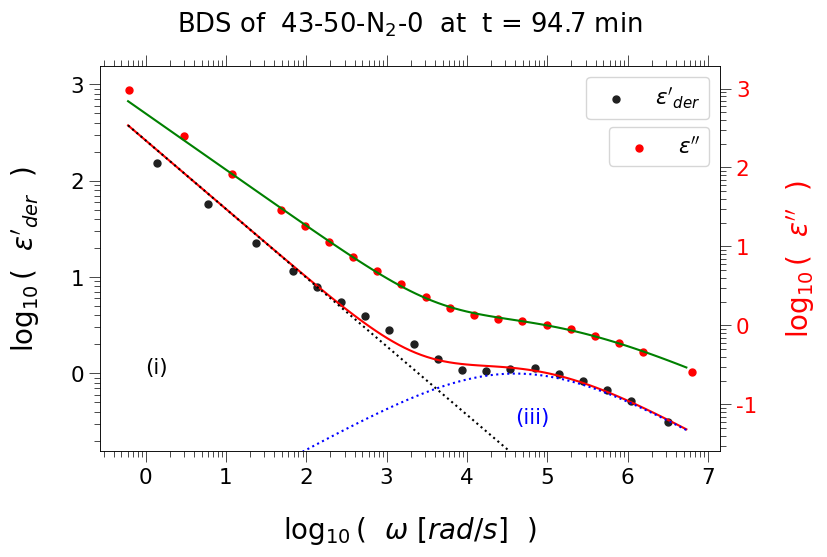

fit score 555898.0
fit parameters [3229000.0, 0.6958, 1.667e-06, 4.1, 0.4821, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


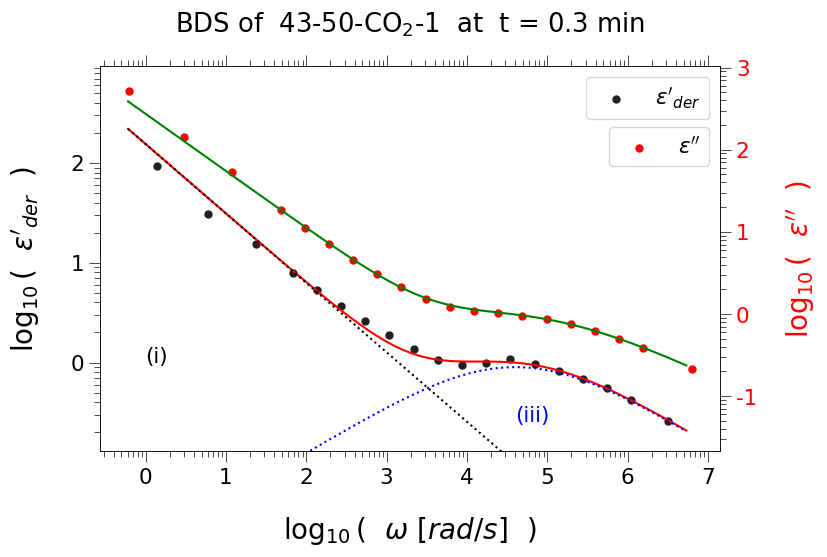

fit score 1177554.0
fit parameters [2634000.0, 0.7051, 1.928e-06, 4.043, 0.4864, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


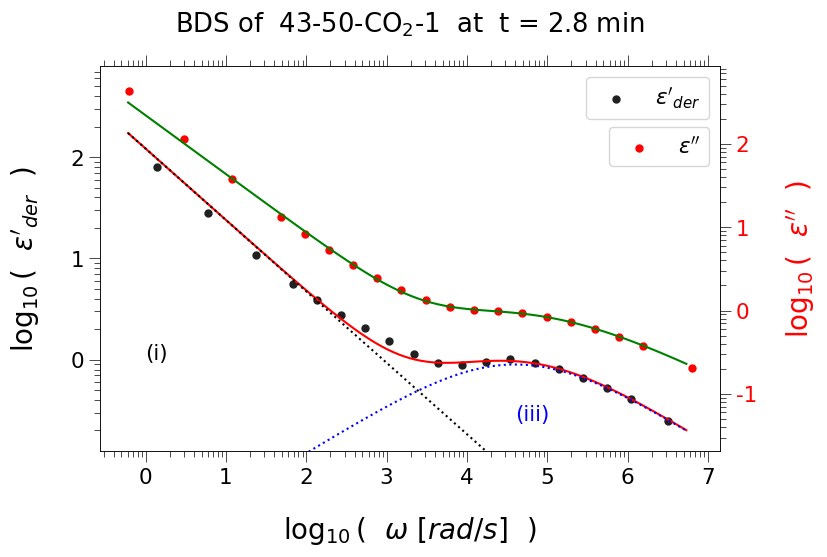

fit score 1349422.0
fit parameters [2141000.0, 0.7017, 1.923e-06, 3.887, 0.4874, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


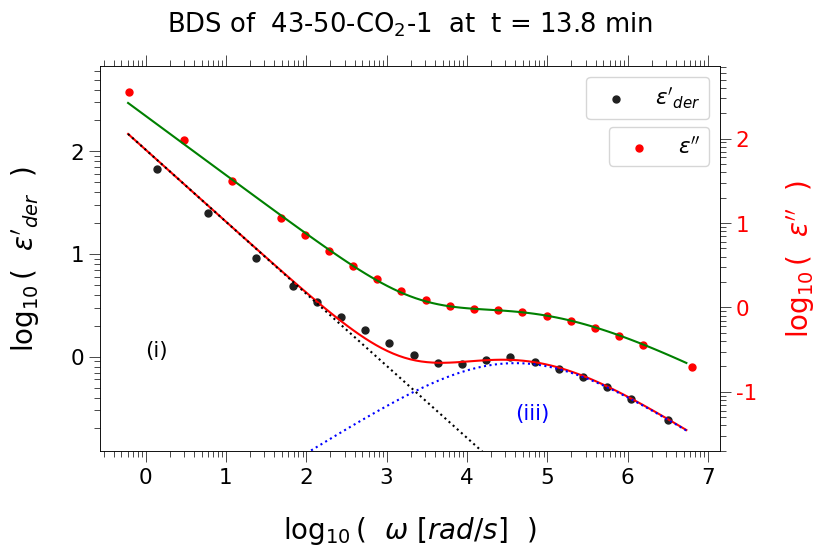

fit score 3245418.0
fit parameters [1425000.0, 0.7118, 3.986e-06, 3.802, 0.4859, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


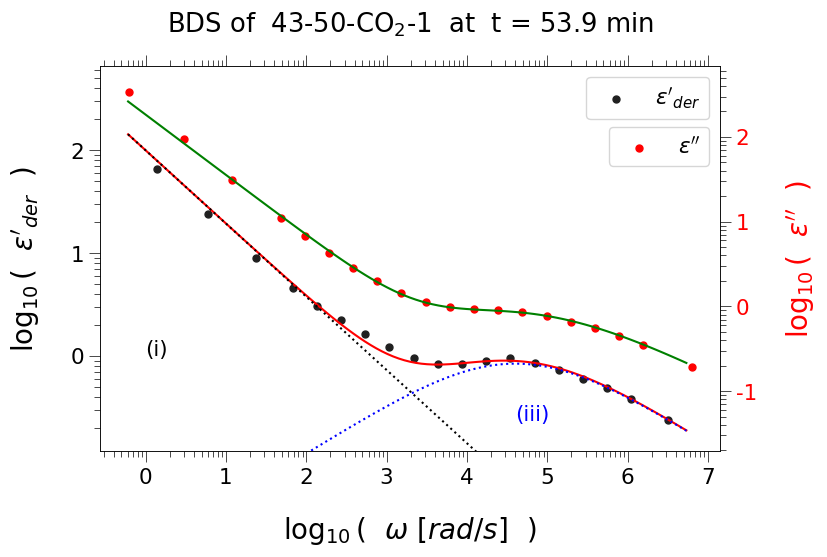

fit score 3795735.0
fit parameters [1414000.0, 0.7138, 4.071e-06, 3.767, 0.486, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


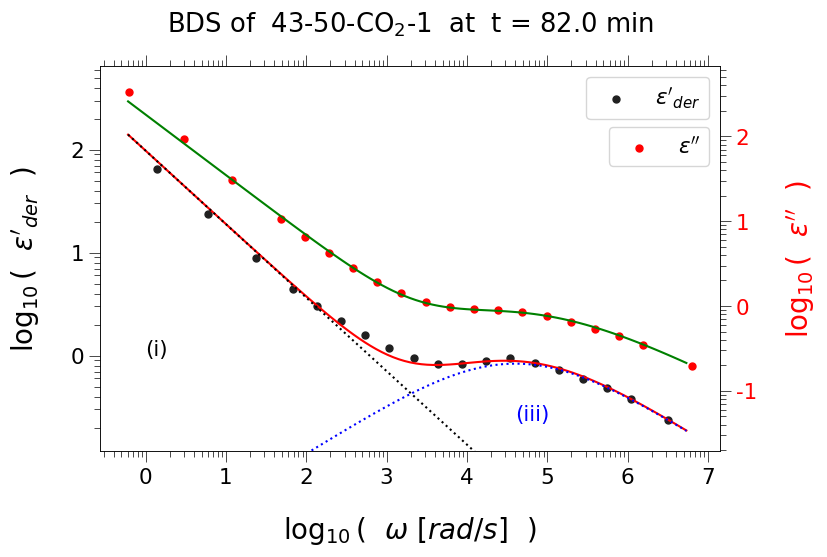

fit score 2559212.0
fit parameters [1184000.0, 0.7151, 4.981e-06, 3.669, 0.4927, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


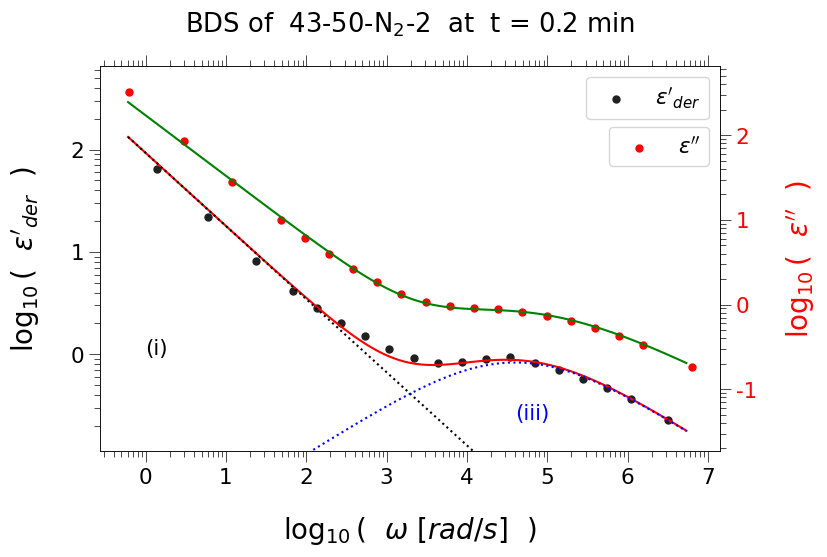

fit score 510675.0
fit parameters [780000.0, 0.6932, 4.098e-06, 3.398, 0.5131, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


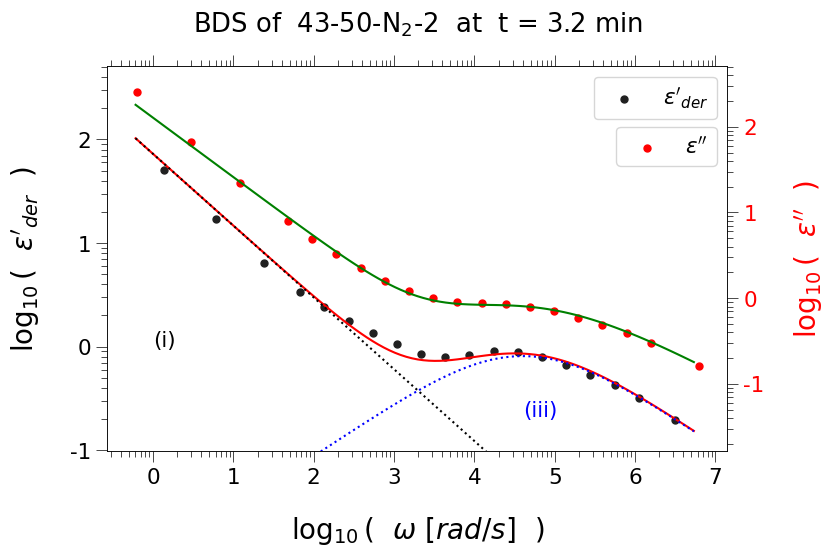

FALLBACK 1:  48021.0
fit score 39983.0
fit parameters [308100.0, 0.645, 3.19e-06, 3.13, 0.5281, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


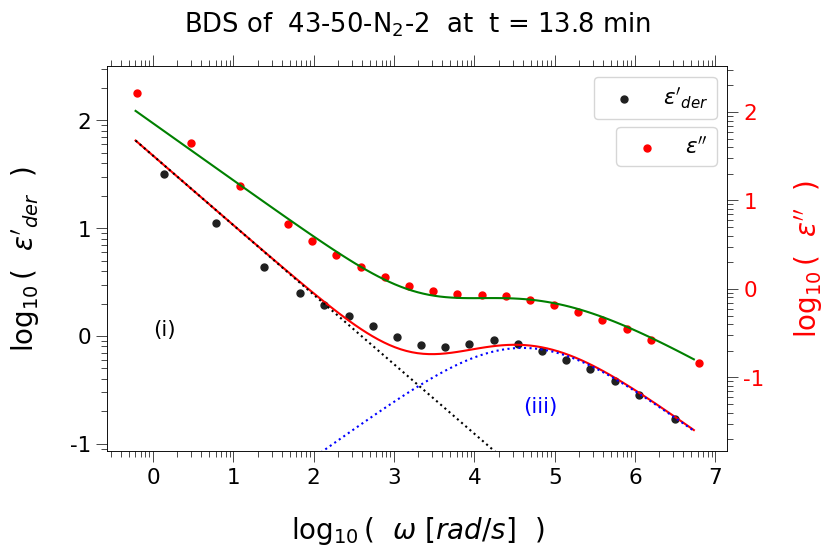

FALLBACK 1:  34241.0
FALLBACK 1:  33279.0
FALLBACK 1:  32893.0
FALLBACK 1:  32782.0
FALLBACK 1:  32438.0
FALLBACK 1:  32005.0
FALLBACK 1:  32168.0
FALLBACK 1:  32661.0
FALLBACK 1:  33569.0
FALLBACK 1:  34448.0
FALLBACK 1:  35189.0
FALLBACK 1:  35568.0
FALLBACK 1:  35882.0
FALLBACK 1:  36828.0
FALLBACK 1:  37856.0
FALLBACK 1:  38792.0
FALLBACK 1:  39844.0
FALLBACK 1:  40873.0
FALLBACK 1:  41883.0
FALLBACK 1:  43013.0
FALLBACK 1:  47020.0
FALLBACK 1:  48248.0
fit score 485965.0
fit parameters [962800.0, 0.6859, 3.984e-06, 3.59, 0.5186, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


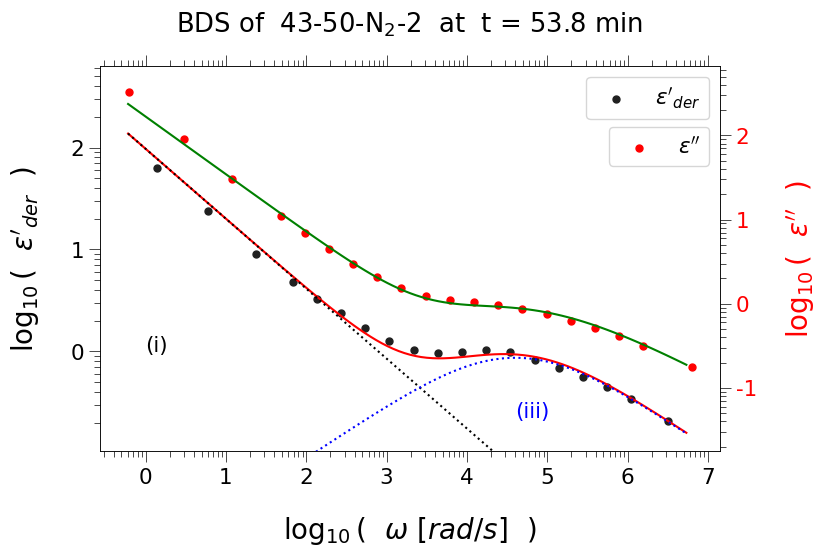

fit score 2579988.0
fit parameters [2817000.0, 0.7127, 3.325e-06, 3.943, 0.5105, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


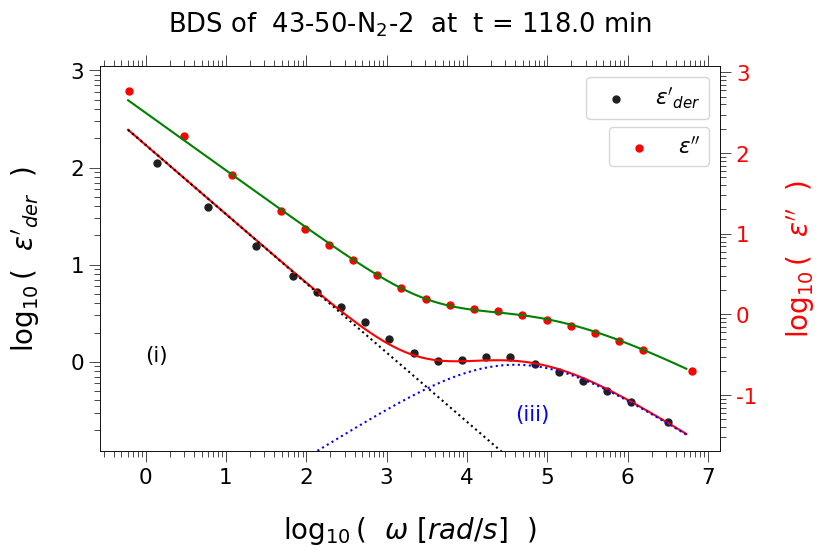

fit score 747816.0
fit parameters [1257000.0, 0.7325, 8.992e-06, 3.914, 0.5085, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


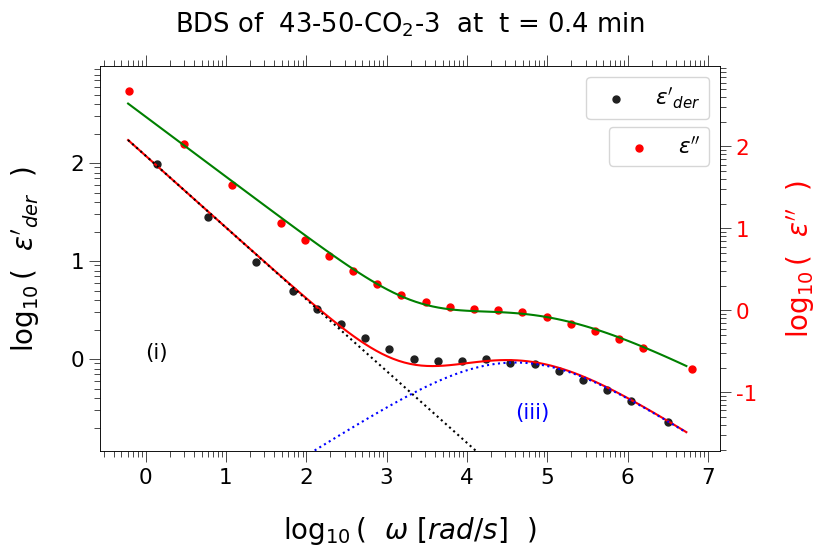

fit score 341584.0
fit parameters [777600.0, 0.6947, 4.704e-06, 3.461, 0.5173, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


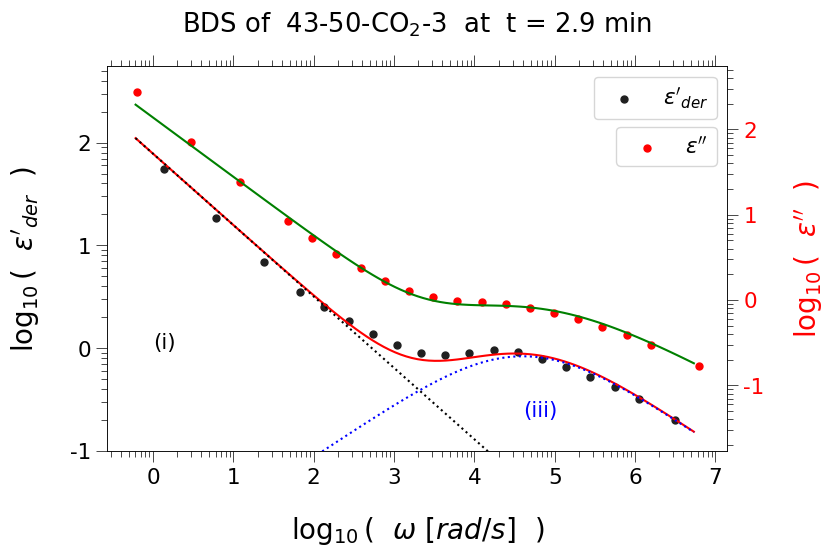

fit score 56321.0
fit parameters [299600.0, 0.6485, 3.369e-06, 3.059, 0.5313, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


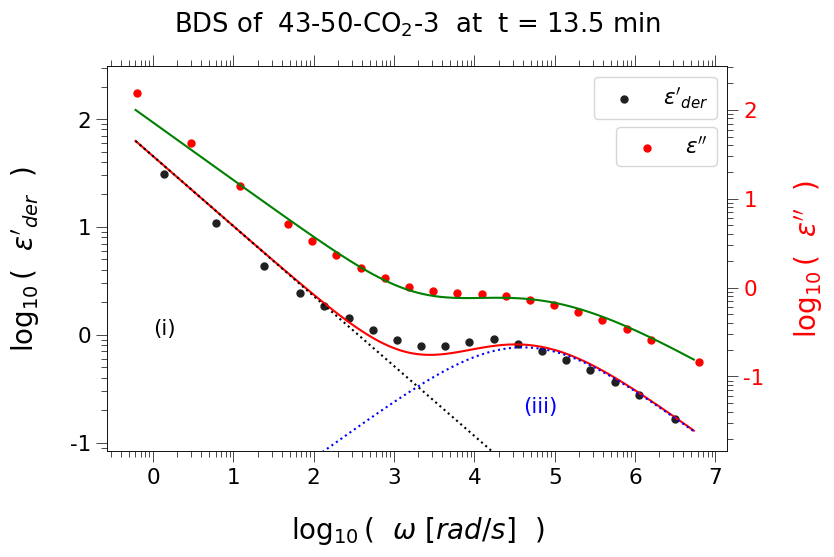

FALLBACK 1:  46621.0
FALLBACK 1:  45614.0
FALLBACK 1:  44029.0
FALLBACK 1:  43569.0
FALLBACK 1:  43193.0
FALLBACK 1:  45206.0
FALLBACK 1:  45737.0
FALLBACK 1:  46265.0
FALLBACK 1:  48090.0
FALLBACK 1:  49054.0
FALLBACK 1:  49717.0
FALLBACK 1:  49414.0
FALLBACK 1:  48989.0
fit score 109578.0
fit parameters [283000.0, 0.6459, 3.449e-06, 3.148, 0.5155, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


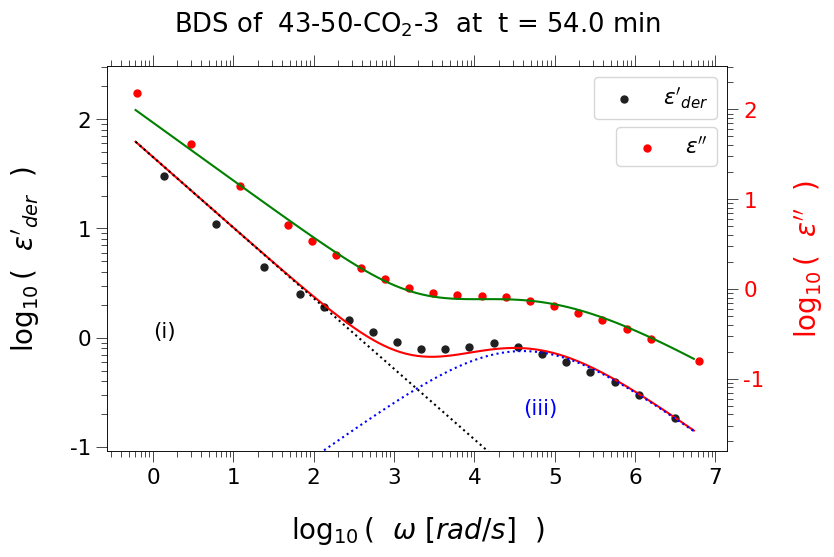

fit score 237518.0
fit parameters [435100.0, 0.6707, 3.79e-06, 3.245, 0.5091, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


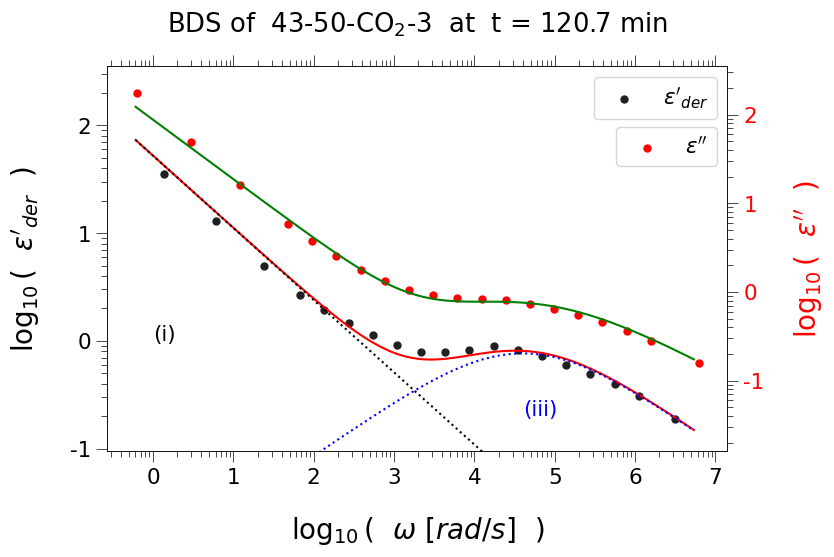

[2.0, 0.7, 0.1, 0.1, 0.5, 400000.0]
0 0 IndexError :  index 0 is out of bounds for axis 0 with size 0
[2.0, 0.7, 0.1, 0.1, 0.5, 400000.0]
0 1 RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
FALLBACK 1:  969.0
FALLBACK 1:  1054.0
FALLBACK 1:  1120.0
FALLBACK 1:  1201.0
FALLBACK 1:  1280.0
FALLBACK 1:  1337.0
FALLBACK 1:  1356.0
FALLBACK 1:  1387.0
FALLBACK 1:  1408.0
FALLBACK 1:  1481.0
FALLBACK 1:  1578.0
FALLBACK 1:  1613.0
FALLBACK 1:  1622.0
FALLBACK 1:  1656.0
FALLBACK 1:  1717.0
FALLBACK 1:  1774.0
FALLBACK 1:  1818.0
FALLBACK 1:  1875.0
FALLBACK 1:  1937.0
FALLBACK 1:  2398.0
FALLBACK 1:  2485.0
FALLBACK 1:  3037.0
FALLBACK 1:  3201.0
FALLBACK 1:  3552.0
FALLBACK 1:  4191.0
FALLBACK 1:  4431.0
FALLBACK 1:  4702.0
FALLBACK 1:  5583.0
FALLBACK 1:  6229.0
FALLBACK 1:  7299.0
FALLBACK 1:  8817.0
FALLBACK 1:  9360.0
FALLBACK 1:  9956.0
FALLBACK 1:  12306.0
FALLBACK 1:  12866.0
FALLBACK 1:  13426.0
FALLBACK 1:  16560.0
FALLBACK 1:  

/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


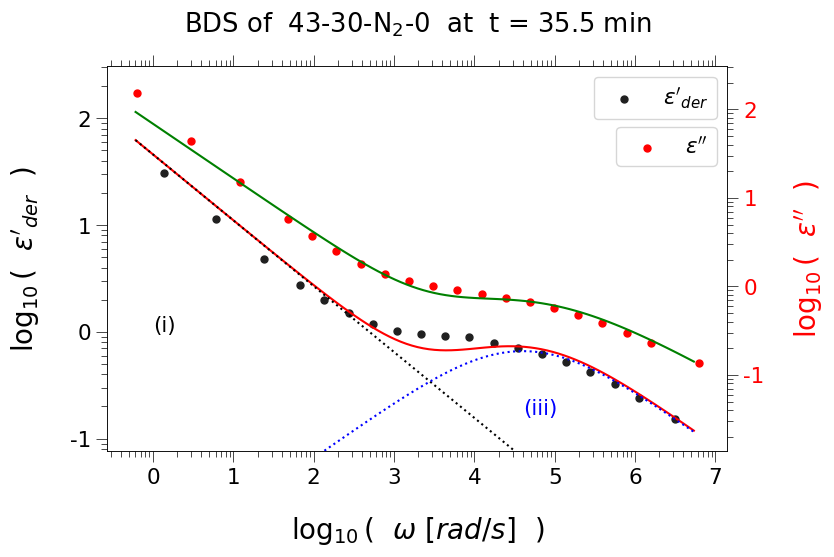

fit score 18762.0
fit parameters [228000.0, 0.6187, 2.896e-06, 2.707, 0.5234, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


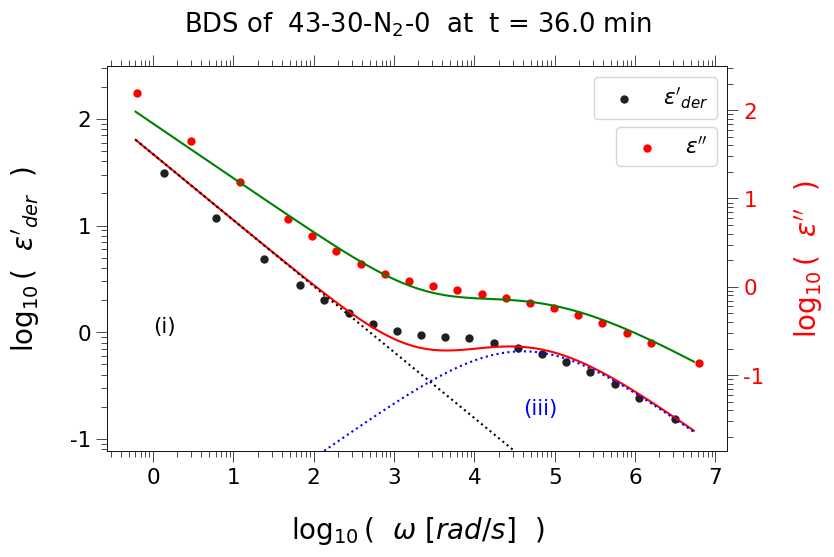

FALLBACK 1:  19859.0
fit score 19859.0
fit parameters [235600.0, 0.6206, 2.954e-06, 2.72, 0.5232, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


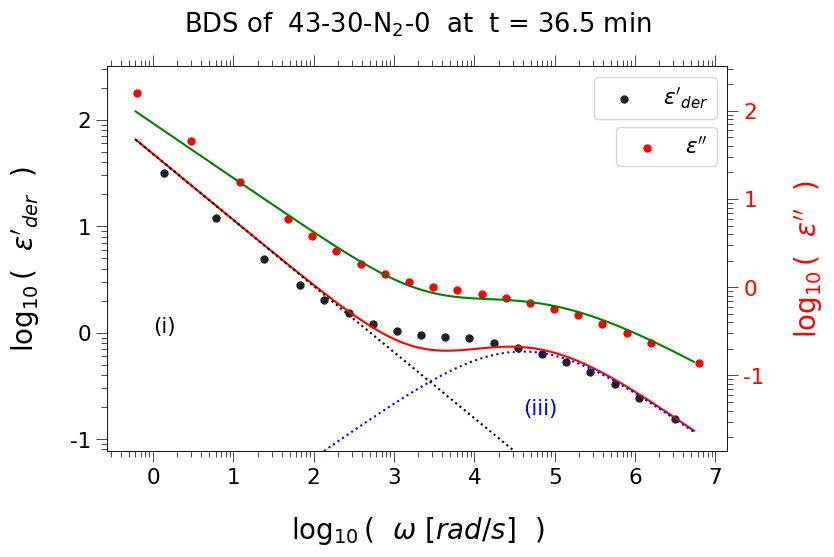

FALLBACK 1:  20968.0
FALLBACK 1:  22034.0
FALLBACK 1:  23197.0
FALLBACK 1:  24524.0
FALLBACK 1:  25864.0
FALLBACK 1:  27186.0
FALLBACK 1:  28463.0
FALLBACK 1:  29780.0
FALLBACK 1:  34129.0
FALLBACK 1:  37926.0
FALLBACK 1:  42463.0
fit score 99084.0
fit parameters [658800.0, 0.6719, 4.306e-06, 3.109, 0.5169, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


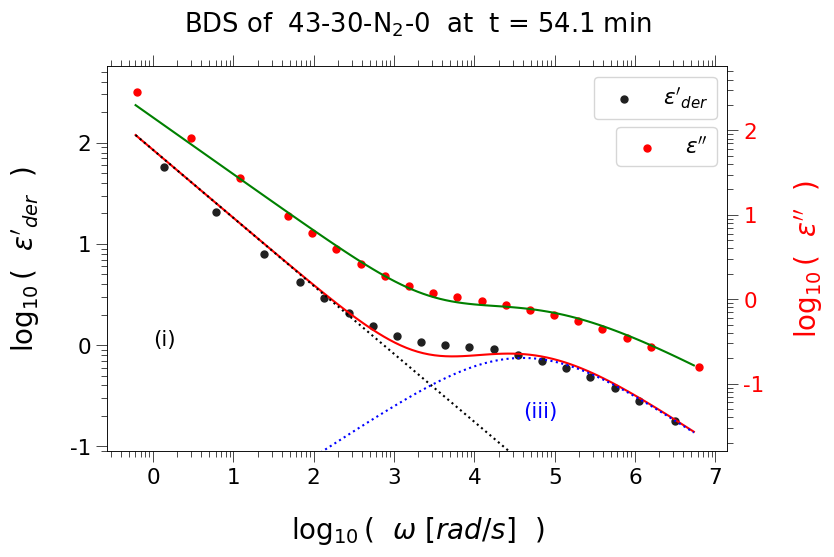

fit score 10895547.0
fit parameters [6237000.0, 0.773, 9.247e-06, 3.931, 0.5048, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


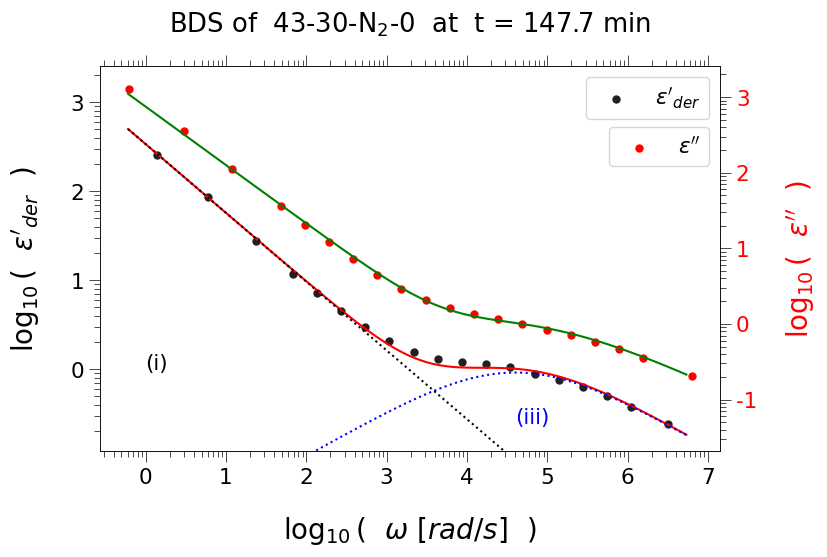

fit score 7558191.0
fit parameters [3060000.0, 0.7733, 2.147e-05, 3.936, 0.4996, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


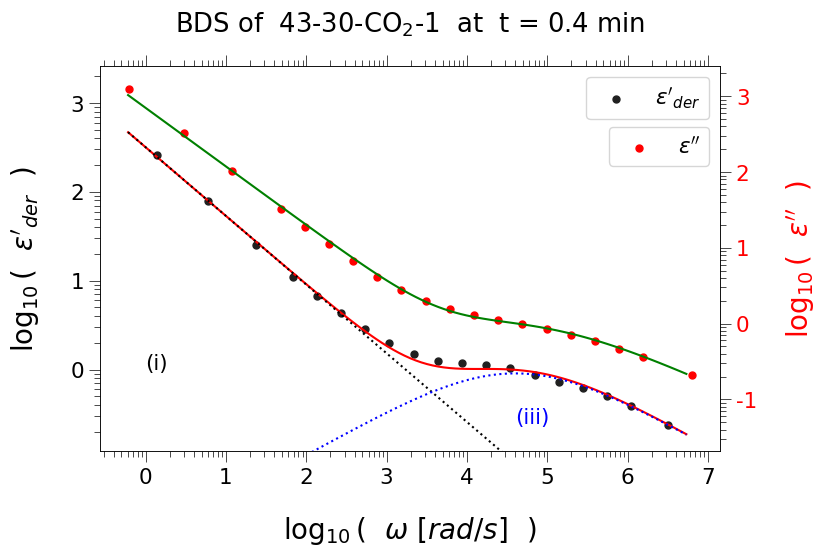

fit score 6532596.0
fit parameters [3097000.0, 0.7599, 1.259e-05, 3.708, 0.5095, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


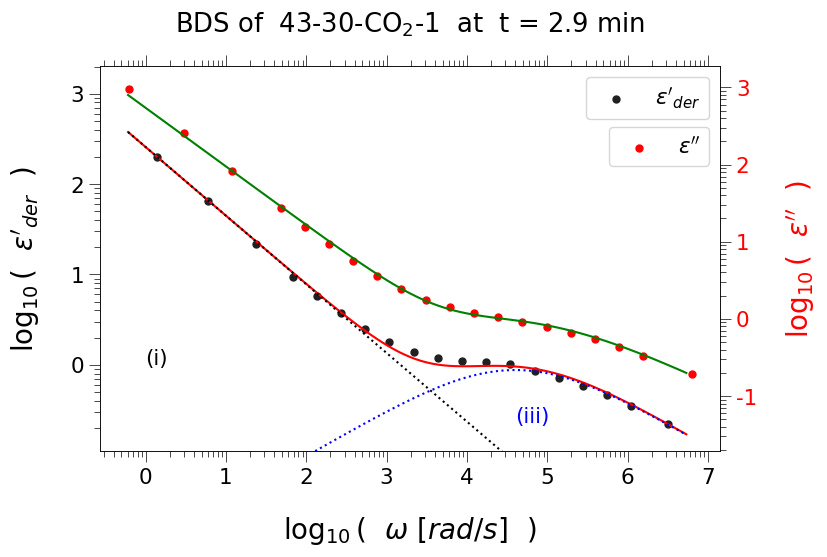

fit score 2393550.0
fit parameters [2110000.0, 0.7468, 1.057e-05, 3.457, 0.5212, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


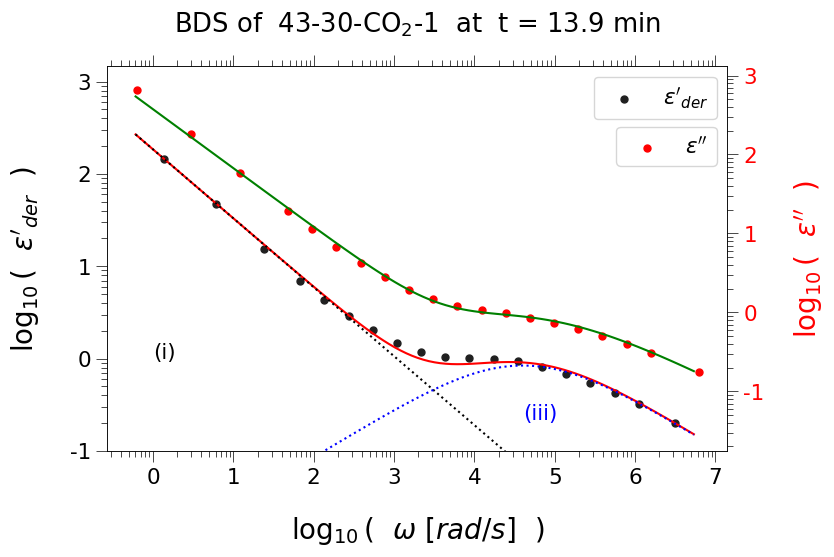

fit score 1787506.0
fit parameters [1204000.0, 0.7251, 1.076e-05, 3.401, 0.5177, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


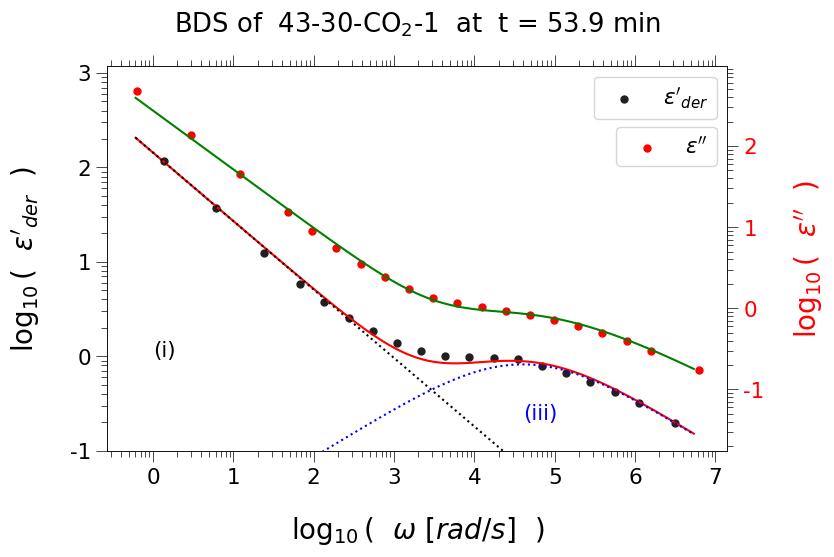

fit score 5023867.0
fit parameters [1566000.0, 0.7367, 1.254e-05, 3.559, 0.5116, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


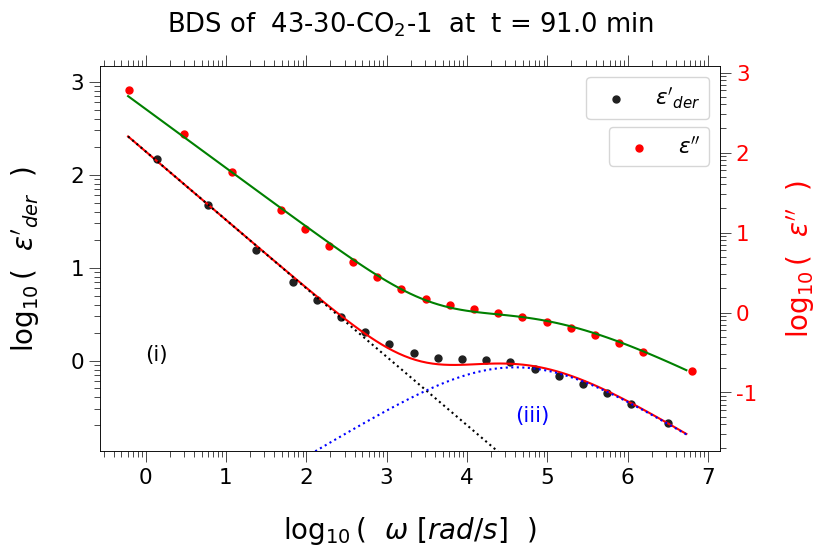

fit score 6057820.0
fit parameters [1298000.0, 0.7425, 1.854e-05, 3.579, 0.5116, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


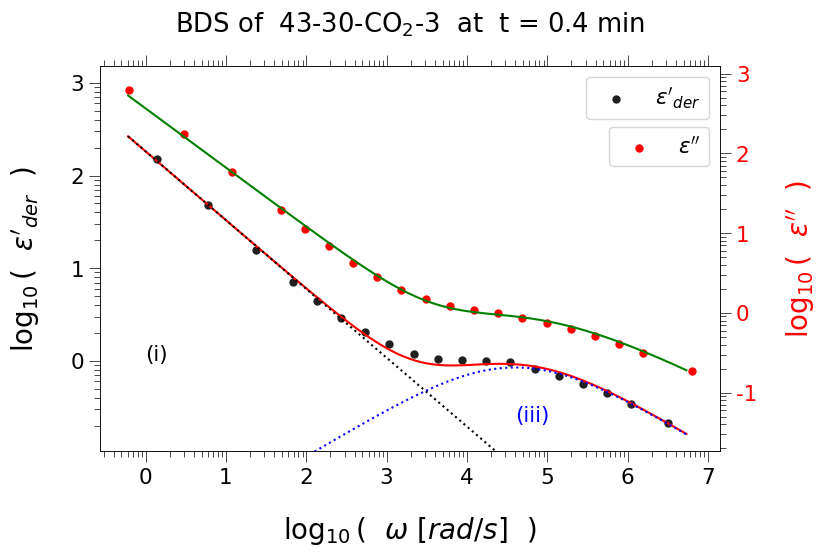

fit score 3716580.0
fit parameters [1370000.0, 0.7391, 1.425e-05, 3.48, 0.5165, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


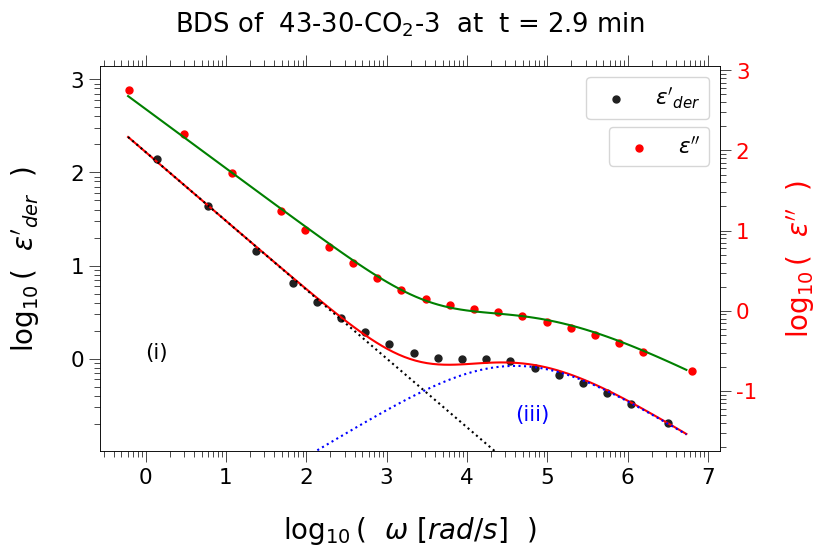

fit score 1267173.0
fit parameters [998600.0, 0.7251, 1.219e-05, 3.281, 0.5262, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


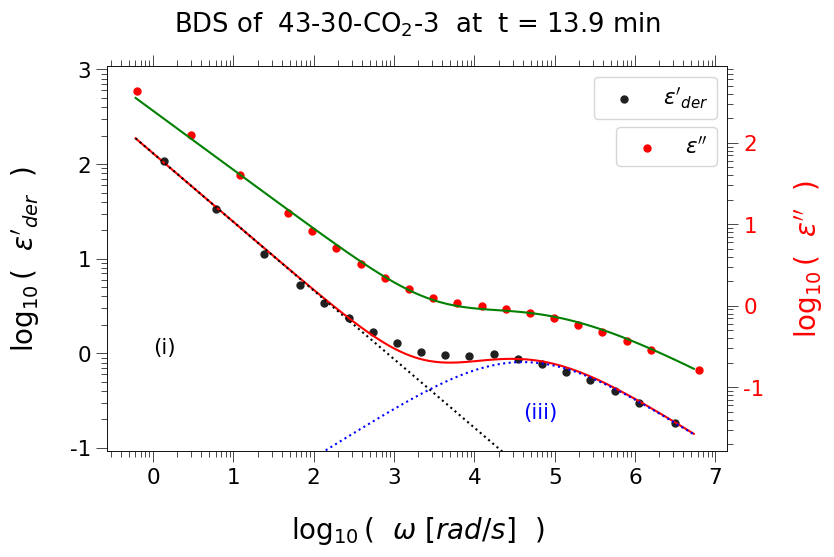

fit score 1591461.0
fit parameters [928300.0, 0.7149, 1.012e-05, 3.328, 0.5189, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


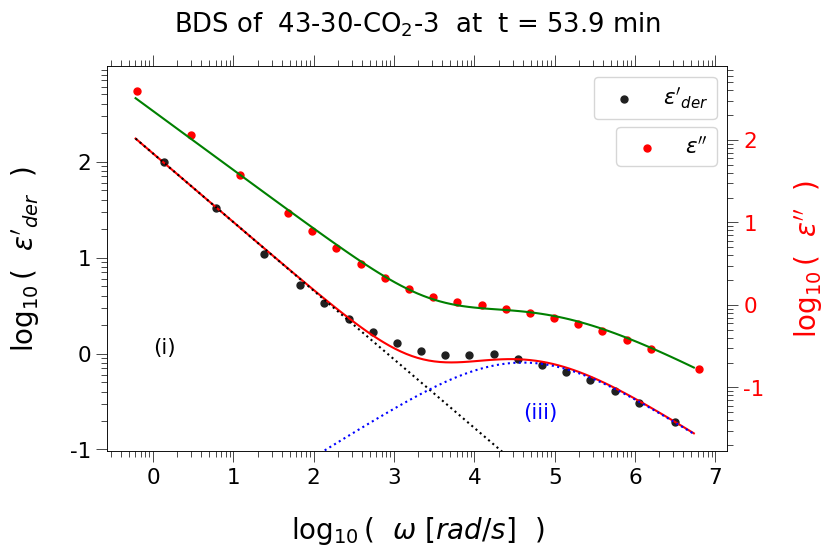

fit score 3510691.0
fit parameters [975900.0, 0.7286, 1.728e-05, 3.505, 0.5139, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


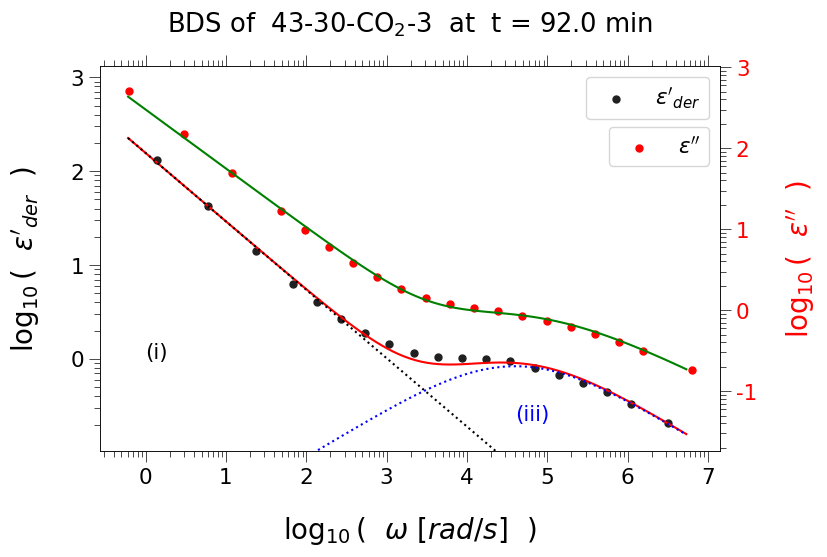

fit score 4027749.0
fit parameters [966300.0, 0.7342, 2.034e-05, 3.556, 0.5127, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


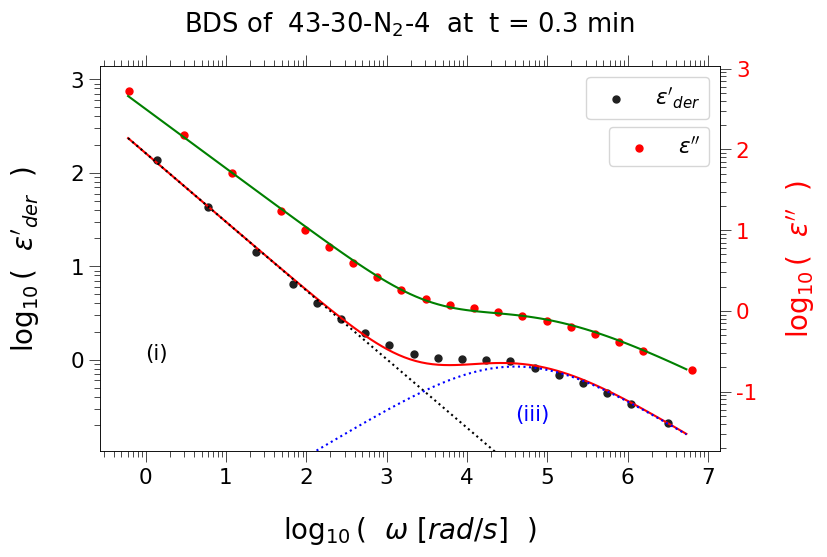

fit score 2589497.0
fit parameters [982100.0, 0.7318, 1.623e-05, 3.433, 0.518, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


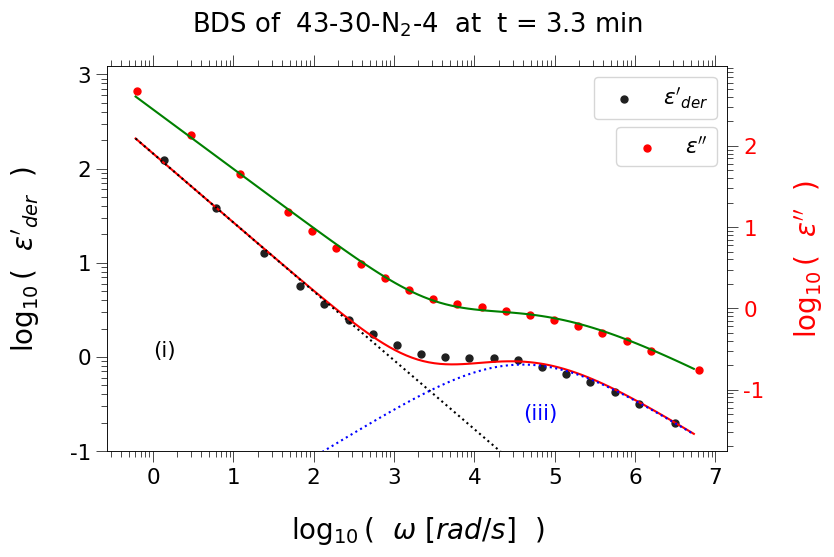

fit score 784549.0
fit parameters [796500.0, 0.7168, 1.105e-05, 3.206, 0.5291, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


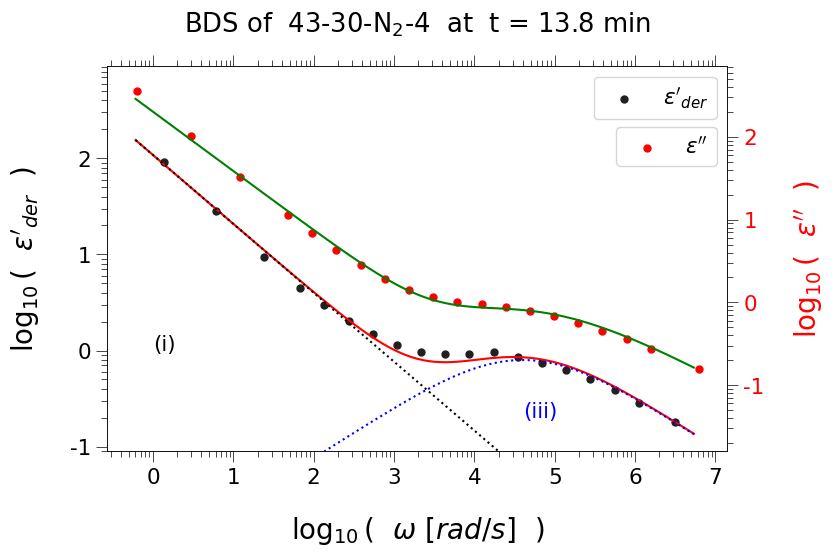

fit score 1407700.0
fit parameters [788100.0, 0.7112, 1.026e-05, 3.3, 0.5208, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


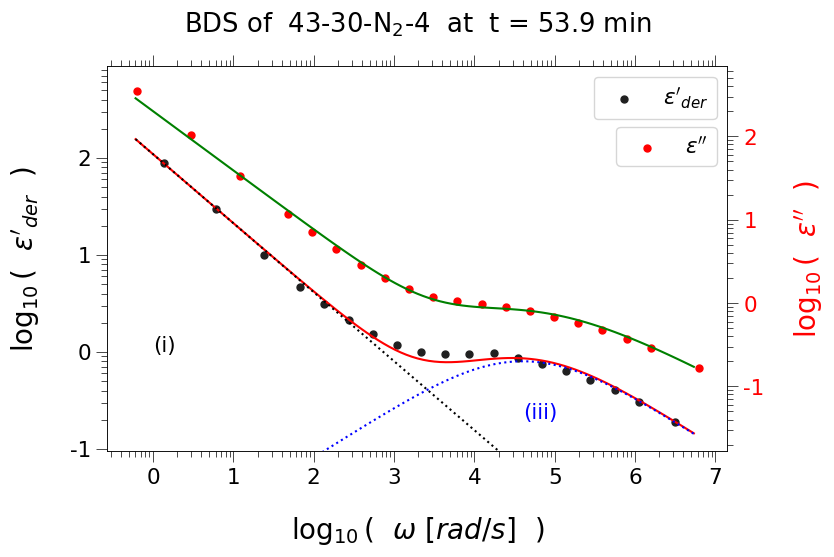

fit score 2273686.0
fit parameters [1478000.0, 0.7508, 2.398e-05, 3.686, 0.5121, 40000.0]


/tmp/ipykernel_17414/833274239.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_17414/833274239.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_17414/833274239.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


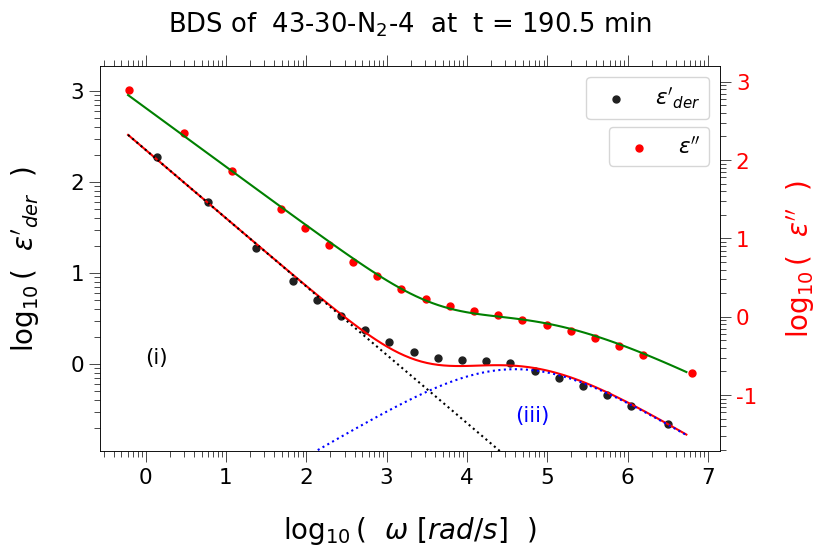

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

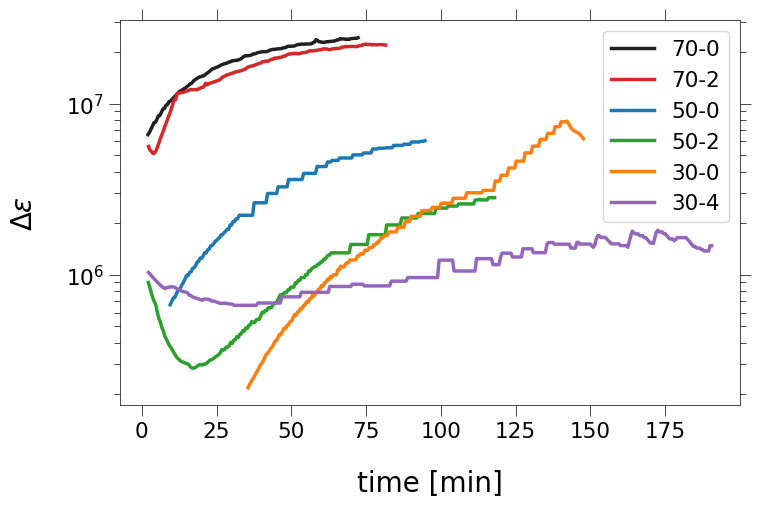

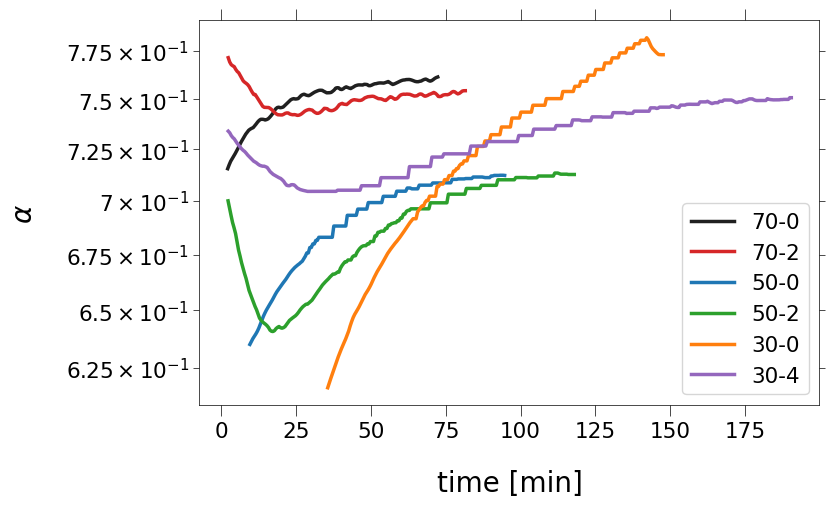

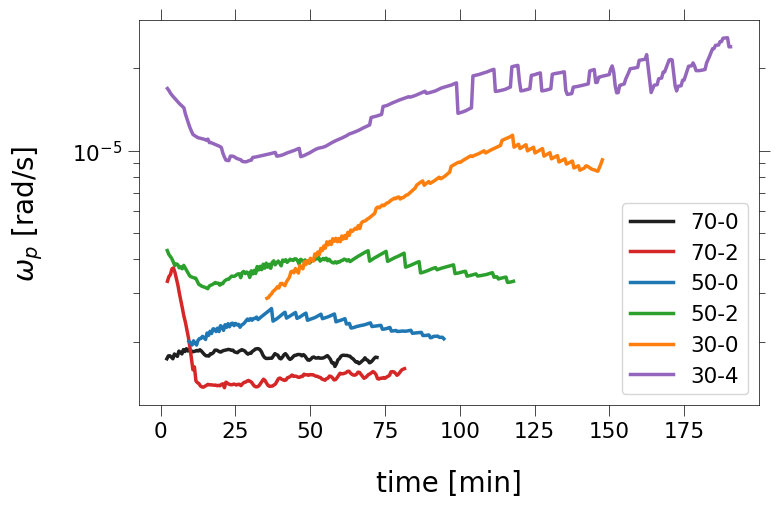

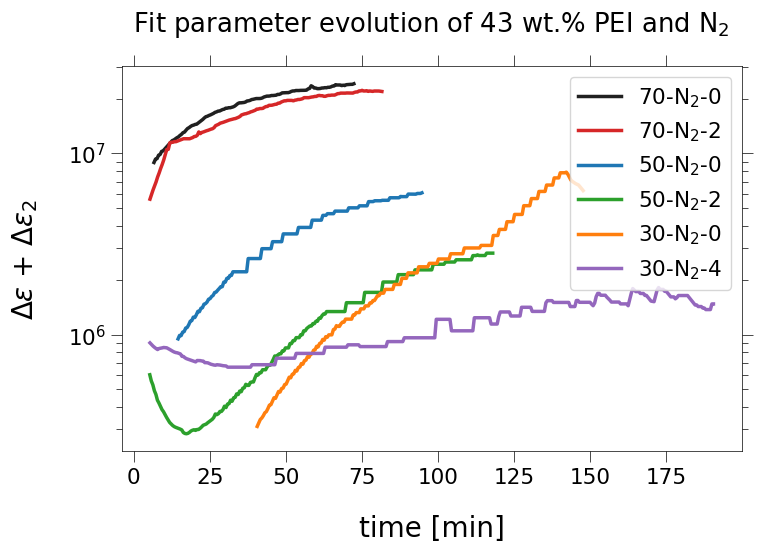

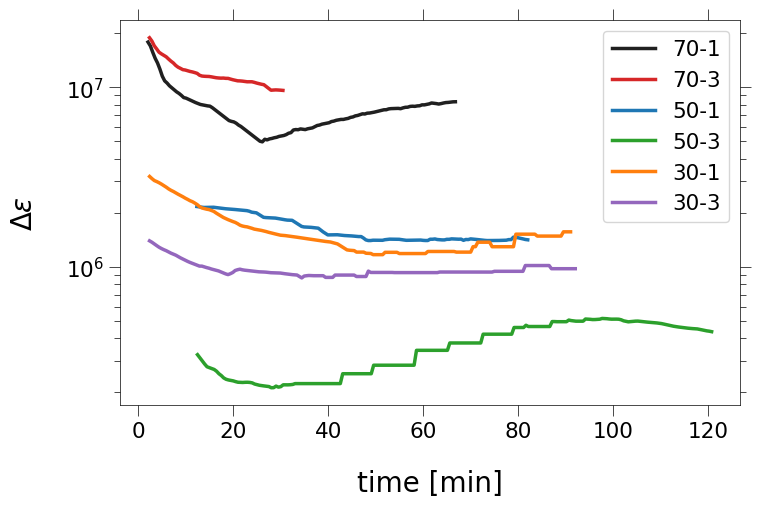

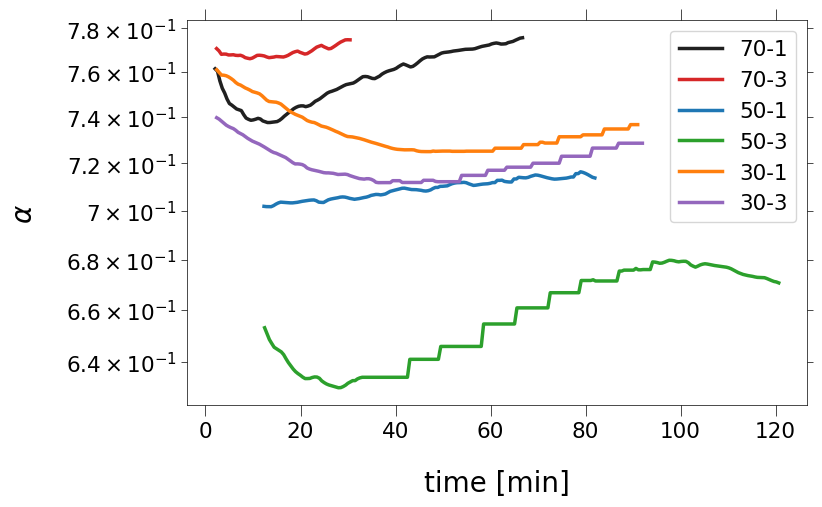

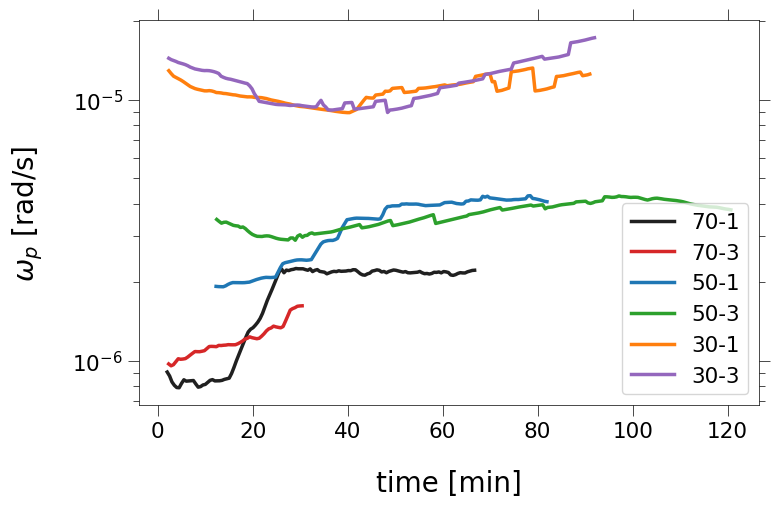

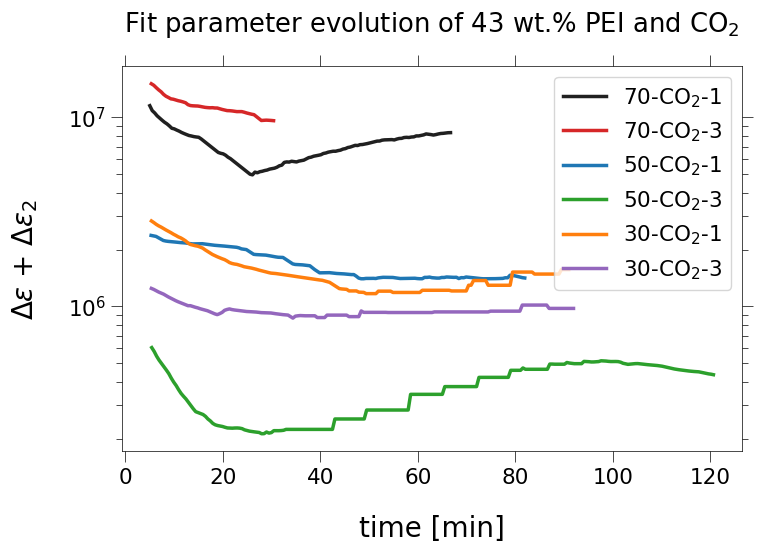

In [7]:
### Plot time evolution of fit parameters

title_text = "Fit parameter evolution of "+ SAMPLE + " and "

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

# j: run with specific temp and gas
# i: parameters

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, lw=2.5)
            #plt.title(title_text + gas)

        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig(results_folder + "/param/"+gas+" "+p_file_labels[i]+".pdf", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, lw=2.5)
        plt.title(title_text + gas)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

[-21967000.0, 33.88, 26685000.0]
[-20284000.0, 41.529, 25161000.0]


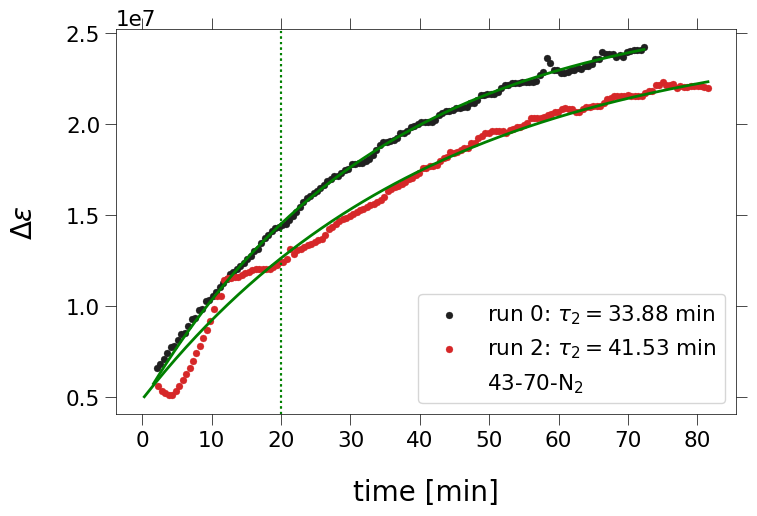

[-12871000.0, 118.36, 11953000.0]
[-9985300000.0, 348900.0, 9984800000.0]


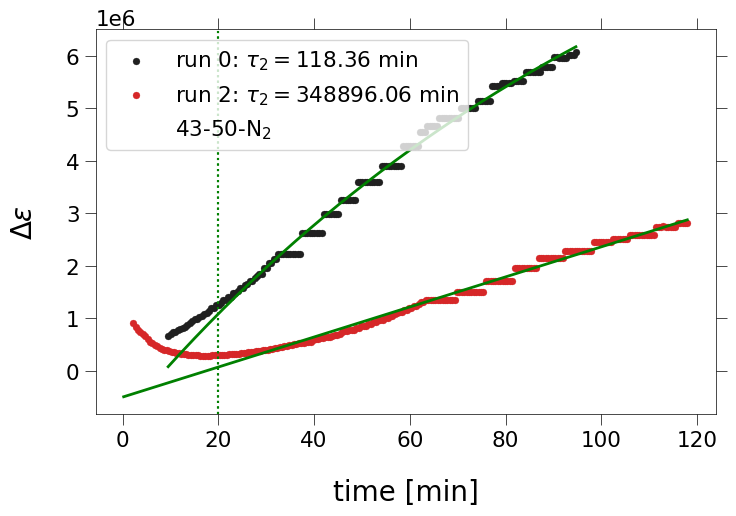

[-600260000.0, 87301.0, 600680000.0]


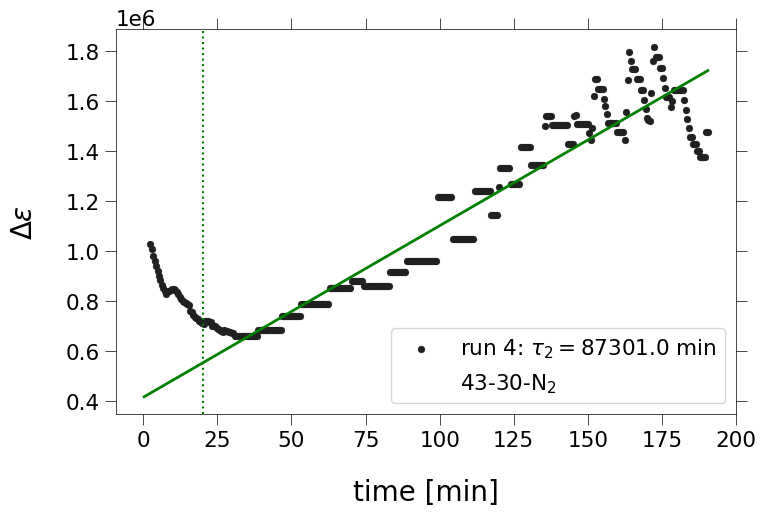

[-0.035528, 21.808, 0.7614]
[-0.027926, 37.834, 0.75706]


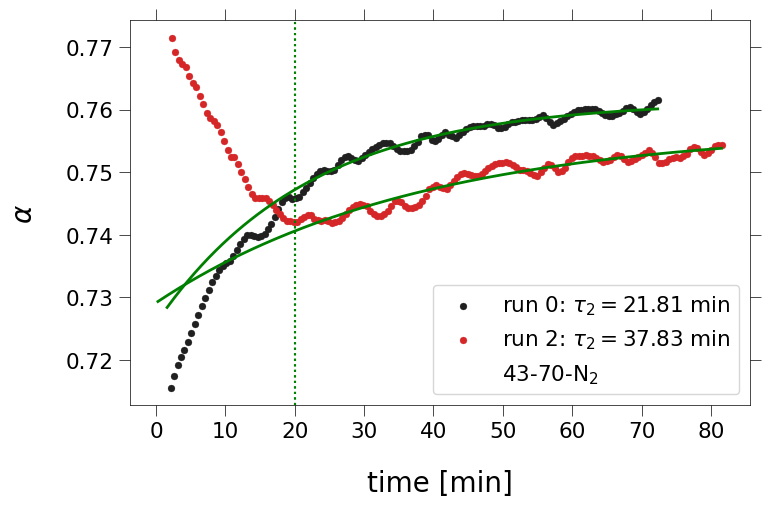

[-0.11868, 26.697, 0.71636]
[-0.13928, 40.238, 0.72231]


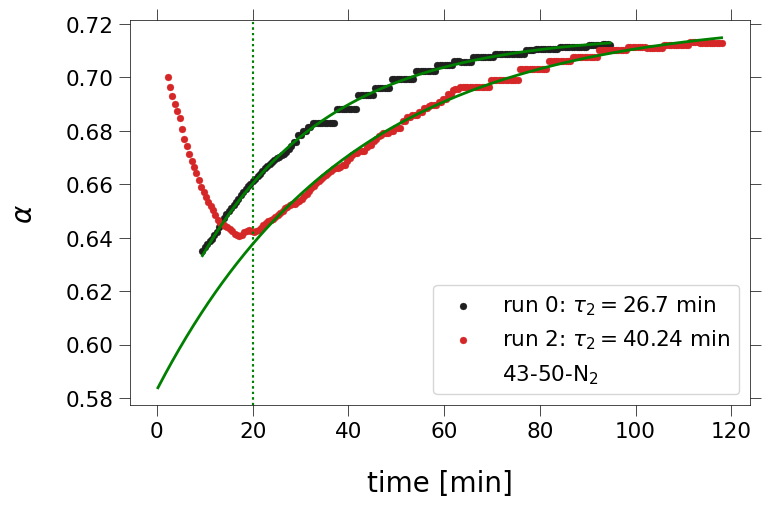

[-0.1037, 186.01, 0.79127]


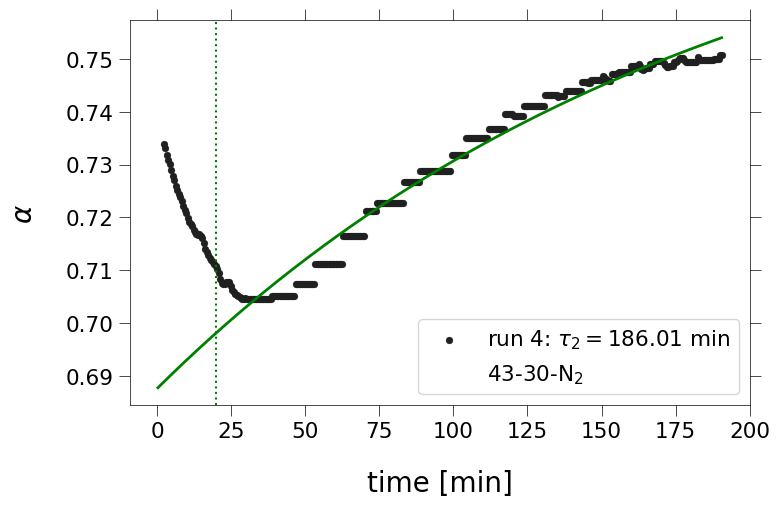

[1.7684e-06, 822040000.0, 1.6235e-09]
[-0.24929, 97083000.0, 0.24929]


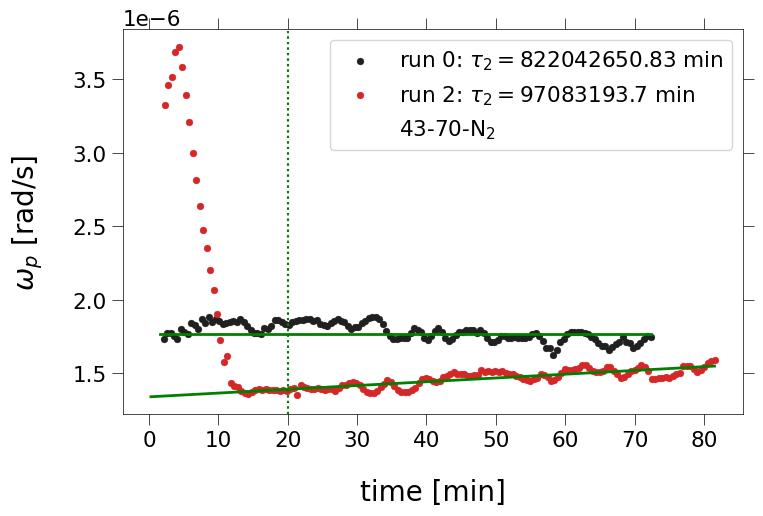

[2.328e-06, 763800000.0, 1.8073e-09]
[3.7794e-06, 516980000.0, 3.5048e-11]


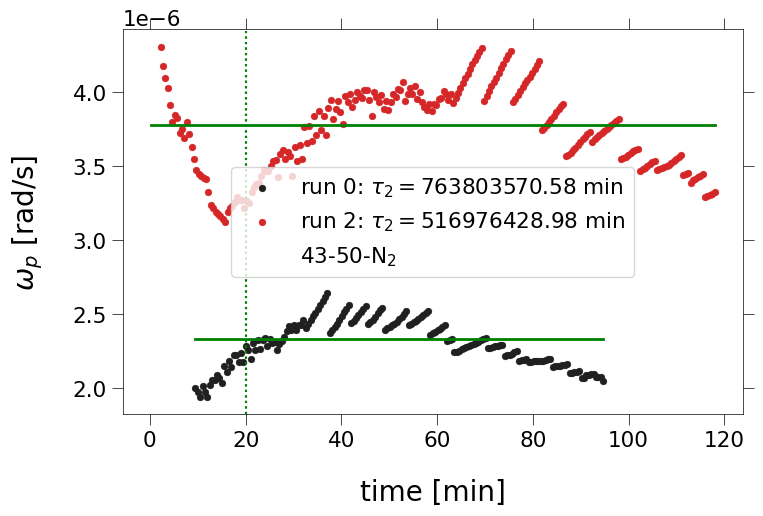

[2.4007e-05, 17.272, 2.2517e-05, 68.901, -2.7183e-05]


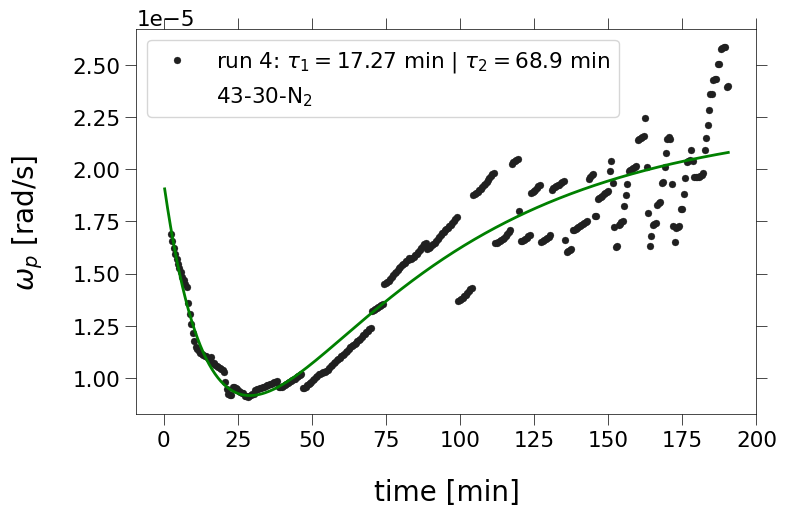

[0.024192, 8.1508, 3.5473]
[4.0285, 20771.0, 4.7898e-09]


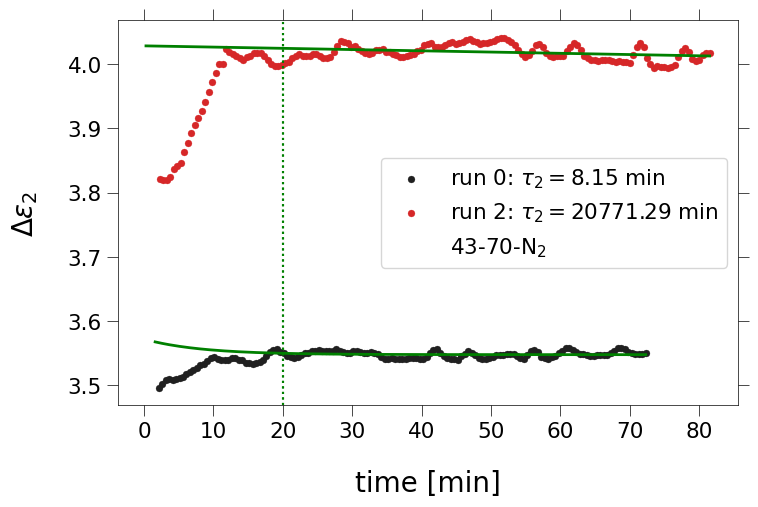

[-1.3557, 28.857, 4.8828]
[-1.4475, 52.504, 4.1097]


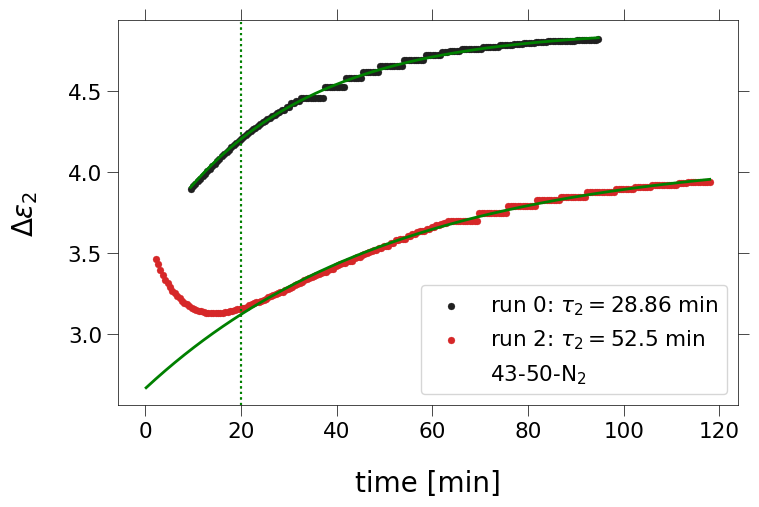

[-0.74239, 0.082884, 3.4877]


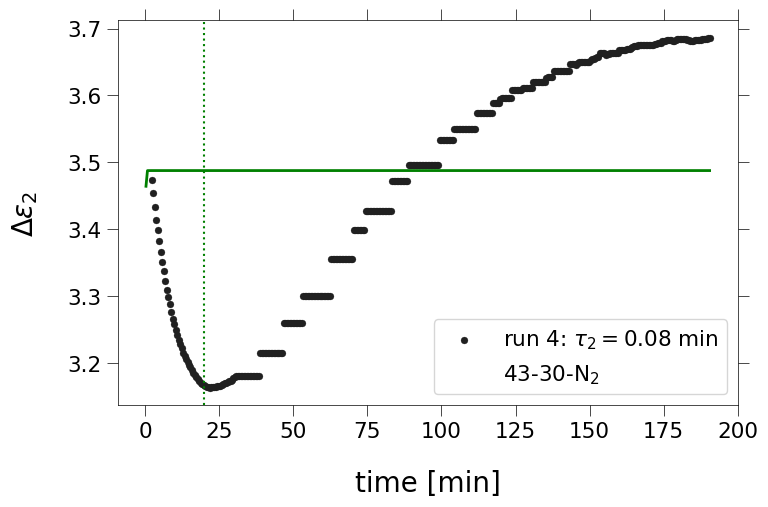

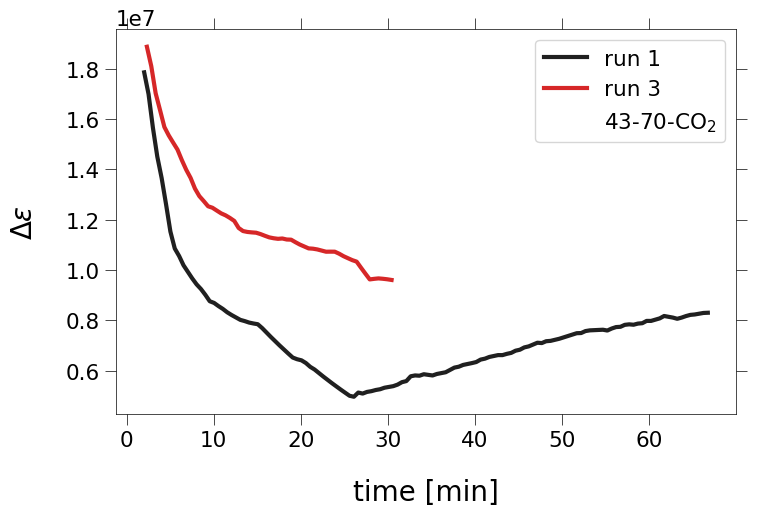

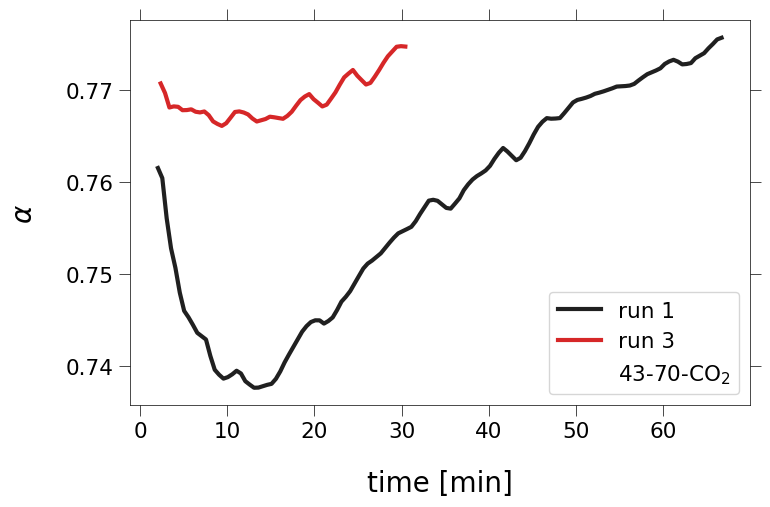

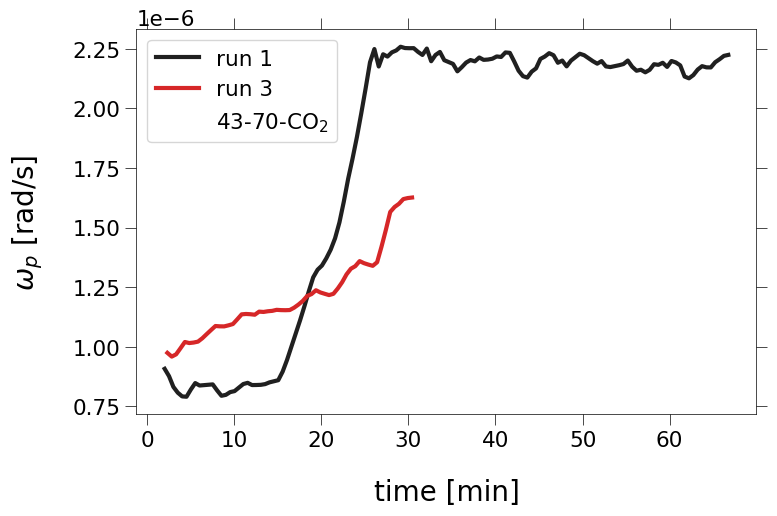

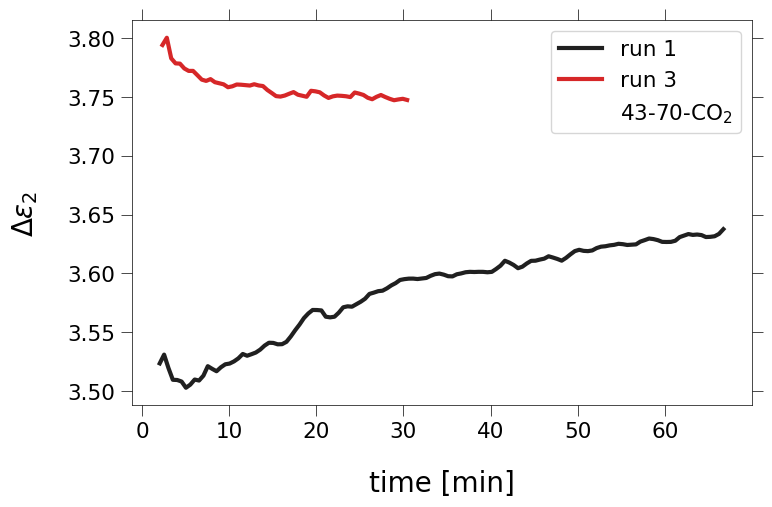

In [12]:
### parameters by temperature in N2

title_text = "Fit parameter evolution / exponential fits for " + SAMPLE_SHORT +"-"

def exp(x, a, b, c) :
    return a * np.exp(-x/b) + c
def exp2(x, a, b, c, d, e) :
    return a * np.exp(-x/b) + c + e * np.exp(-x/d)

# example initial guesses from 20-PEI
p0_2 = [0.8339, 5.2189, 1.2384, 40.091, 0.44262]
p0_1 = [0.61185, 32.341, 1.2989]


look_at = [0, 1, 2, 3]
idp_2exp = ["7010", "7030", "7012", "7032", "7013", "7033", "3042"]

for gas in GASES :
    for i in look_at :

        for temperature in TEMPS :
            if gas[0] == "C" and temperature != 70 :
                continue
            temp = str(temperature)

            plt.xscale('linear')
            plt.yscale('linear')

            for j, id in enumerate(ID) :
                if id[3] != gas[0] or id[0] != temp[0] or (id[0]=='3' and id[-1]=='0') :
                    continue
                label0 = "run " + id[-1]
                label_id = SAMPLE_SHORT + '-' + id[:-2]
                idp = temp + id[-1] + str(i)
                t, p = DT_ALL[j][:], P_ALL[j][i][:]
                cutoff = 100
                pltt = t > 2

                if gas[0] == "C" :
                    plt.plot(t[pltt], p[pltt], label=label0, lw=3)
                    continue


                if idp not in idp_2exp :
                    fitf = exp
                    s = 20
                    fitt2 = (t > s)# & (t < cutoff)
                    try :
                        popt2, _ = curve_fit(fitf, t[fitt2], p[fitt2], p0=p0_1, bounds=((-i_, 0., 0.), (i_, i_, i_)))
                        print([round_sig(pi, 5) for pi in popt2])
                        label = label0 + f': $\\tau_2 = ${np.round(popt2[1],2)} min'

                        y2 = fitf(t, *popt2)
                        plt.plot(t, y2, color='g', lw=2)
                    except Exception as err :
                        print(str(type(err))[8:-2], ": ", err)

                    plt.axvline(s, linestyle=':', color='g')
                    #plt.axvline(cutoff, linestyle=':', color='g')

                else :
                    fitf = exp2
                    fitt = t < cutoff
                    try :
                        popt, _ = curve_fit(fitf, t, p, p0=p0_2, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                        print([round_sig(pi, 5) for pi in popt])
                        tau1 = np.round(min(popt[1], popt[3]),2)
                        tau2 = np.round(max(popt[1], popt[3]),2)
                        label = label0 + f': $\\tau_1 = ${tau1} min | $\\tau_2 = ${tau2} min'

                        y = fitf(t, *popt)
                        plt.plot(t, y, color='g', lw=2)
                    except Exception as err :
                        print(str(type(err))[8:-2], ": ", err)

                    #plt.axvline(cutoff, linestyle=':', color='g')

                plt.scatter(t[pltt], p[pltt], label=label, lw=0.2)
                p_i += 1
            
            plt.plot([],[],color='white',label=label_id)
            plt.xlabel("time [min]")
            plt.ylabel(p_labels[i])
            plt.legend()
            #plt.savefig(results_folder + "/param2/"+label_id+"-"+p_file_labels[i]+".pdf", bbox_inches='tight')
            plt.show()

[-3.551, 4.4909, 108.97, 30.306, -39.113]
[7.5306, 1.2809, 107.7, 28.917, -78.405]


/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


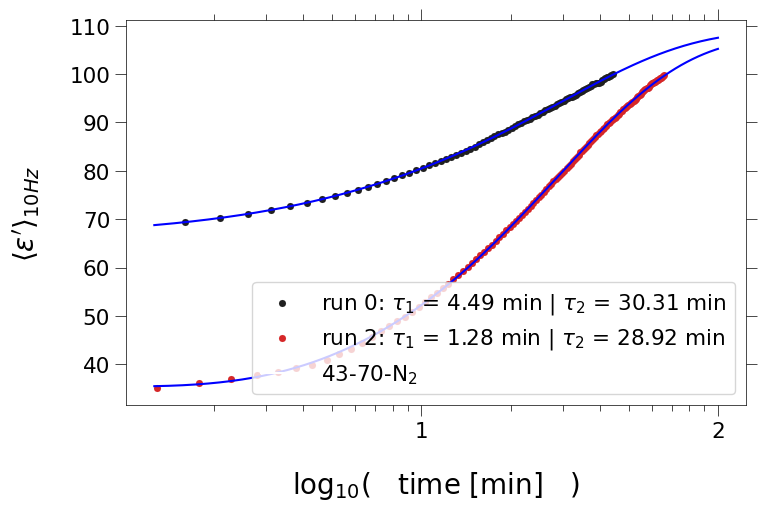

RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
[75.795, 20.0, 59.663, 42.634, -105.37]


/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


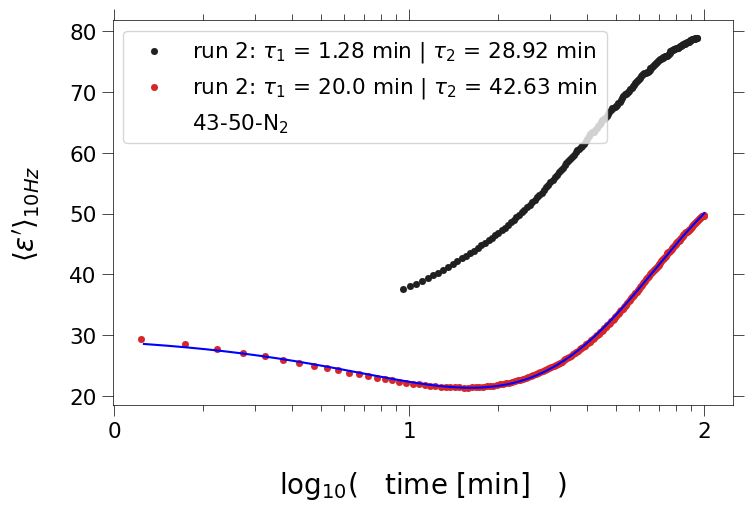

/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


[27.802, 14.663, 103.91, 264.91, -85.22]


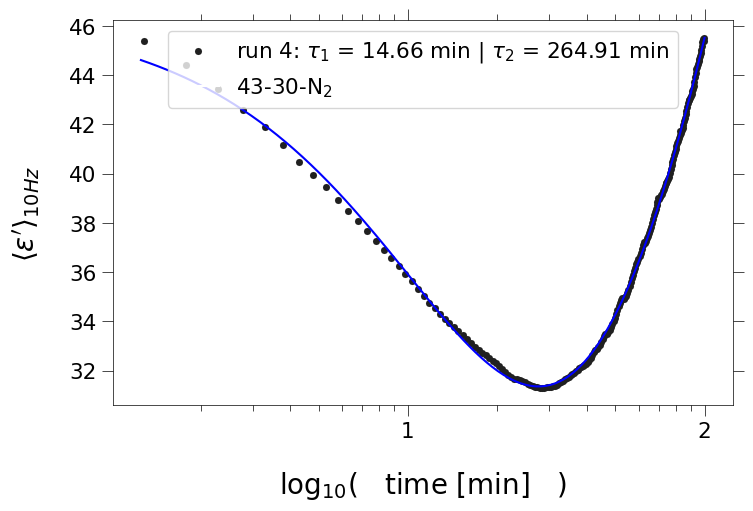

[28.695, 4.3219, 37.142, 18.266, -5.5553]
[11.694, 1.6704, 34.292, 8.2149, 13.446]


/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


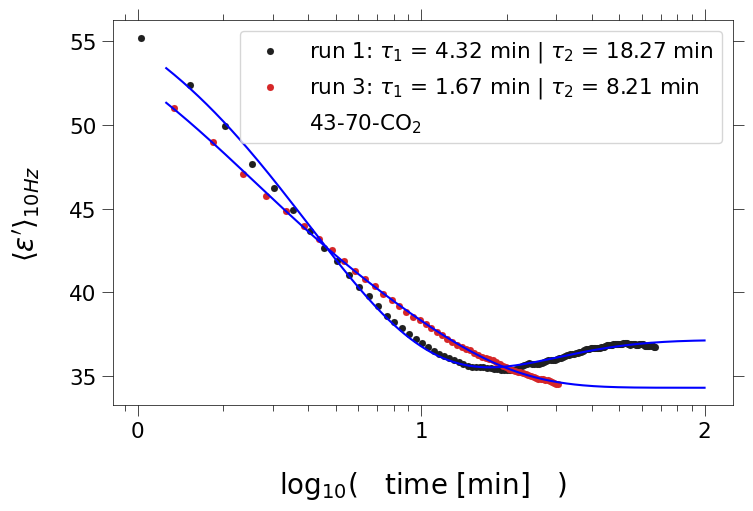

/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


[8.2103, 5.4304, 31.741, 48.439, 4.0372]
[21.582, 10.348, 26.454, 56.509, -15.188]


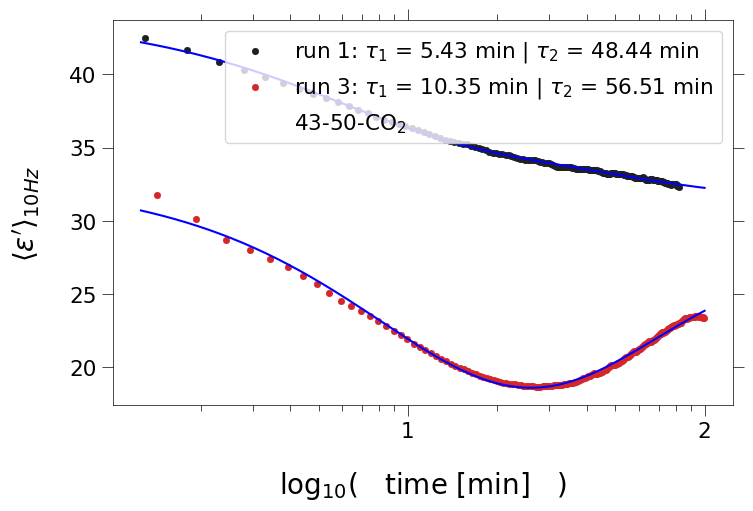

[31.67, 7.1132, 44.272]
[14.962, 4.093, 39.035]


/tmp/ipykernel_17414/2374230327.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


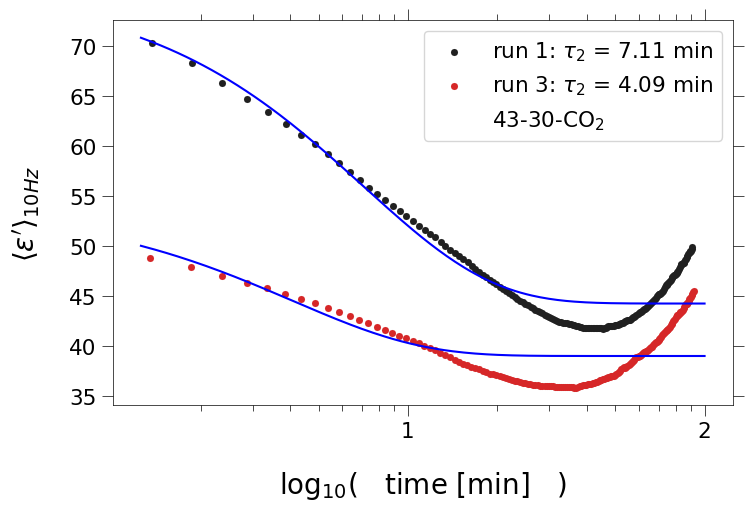

In [13]:
### Plot area

title_text = "Fit area evolution of "

# example initial guesses from PEI-20
p01 = [
    [-3.3728, 0.861, 5.5448, 27.765, -1.6805],
    [-0.94137, 2.764, 2.9277, 32.179, -0.75788],
    [-0.75991, 4.9524, 2.1315, 69.878, -0.4908]]
p02 = [
    [1.2712, 3.2663, 1.4237, 61.509, 0.12305],
    [0.13294, 5.4554, 0.40669, 53.689, 0.06141],
    [0.13294, 5.4554, 0.40669, 53.689, 0.06141]]

t_fit = np.logspace(0.1, 2, 200)

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('log')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) or (id[0]=='3' and id[-1] in ['0', '2']) :
                continue
            label0 = "run " + id[-1]
            label_id = SAMPLE_SHORT + '-' + id[:-2]
            t, a = DT_ALL[j], A_ALL[j]
            fitt = (a < 100) & (t>1) & (t<100)
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                p0 = p01[T_i]
            else :
                p0 = p02[T_i]
            try :
                fitf = exp2
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, 20, i_, 2000, i_)))

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label0 + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                if tau2 > 500 :
                    fitf = exp
                    popt, _ = curve_fit(fitf, t, a, p0=p0[:3], bounds=((-i_, 0, 0.), (i_, i_, i_)))
                    tau2 = np.round(popt[1],2)
                    label = label0 + f': $\\tau_2$ = {tau2} min'


                print([round_sig(pi, 5) for pi in popt])
                plt.plot(t_fit, fitf(t_fit, *popt), color="b")

                #y1 = fitf(t_fit, 0, *popt[1:])
                #y2 = fitf(t_fit, *popt[:-1], 0)
                #plt.plot(t_fit, y1, color='yellow', ls=":")
                #plt.plot(t_fit, y2, color='green', ls=":")

            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)

        ax = plt.gca()
        ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
        plt.plot([],[],color='white',label=label_id)
        plt.xlabel("log$_{10}$(   time [min]   )")
        plt.ylabel("$\\langle\\varepsilon'\\rangle_{10Hz}$")
        plt.legend()
        #plt.savefig(results_folder + "/area/"+label_id+".pdf", bbox_inches='tight')
        plt.show()

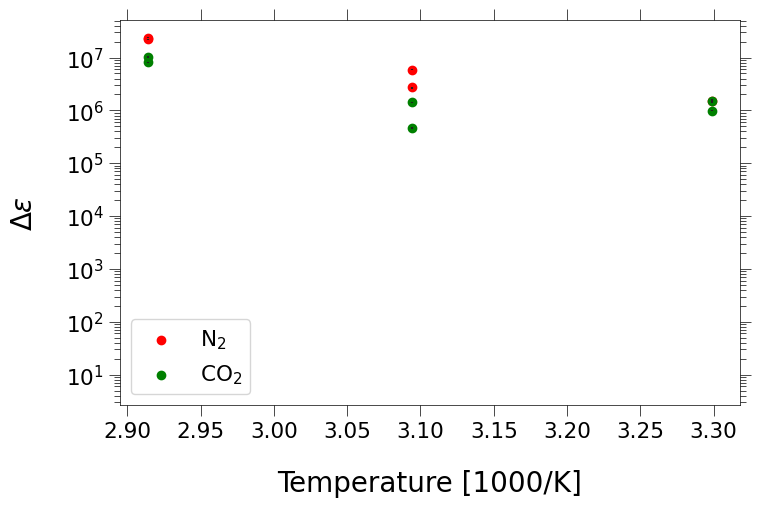

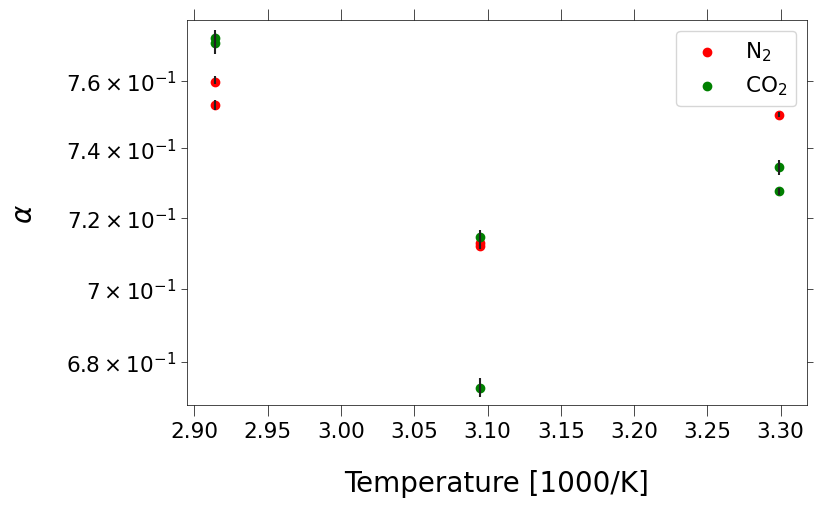

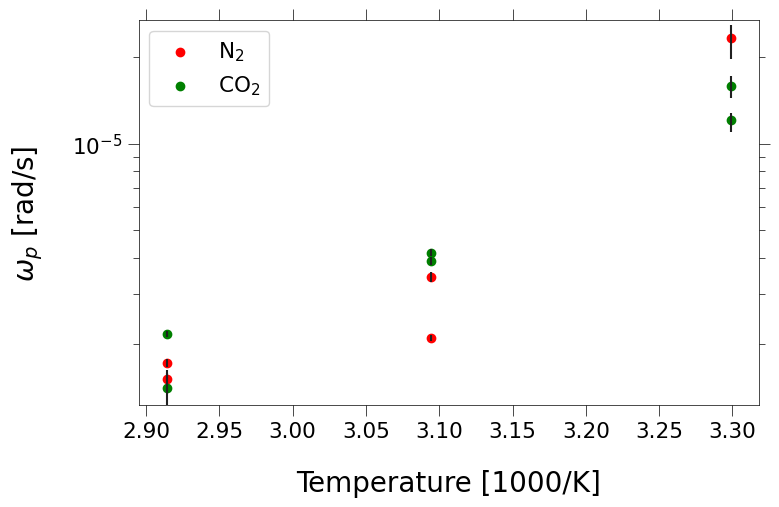

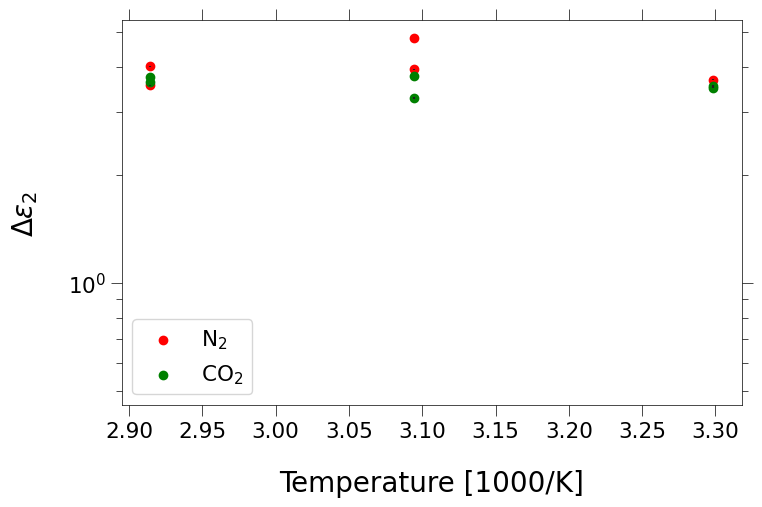

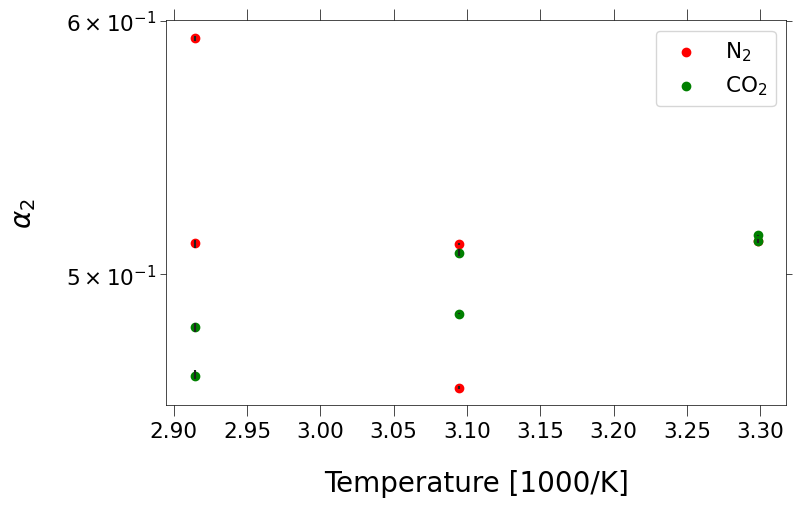

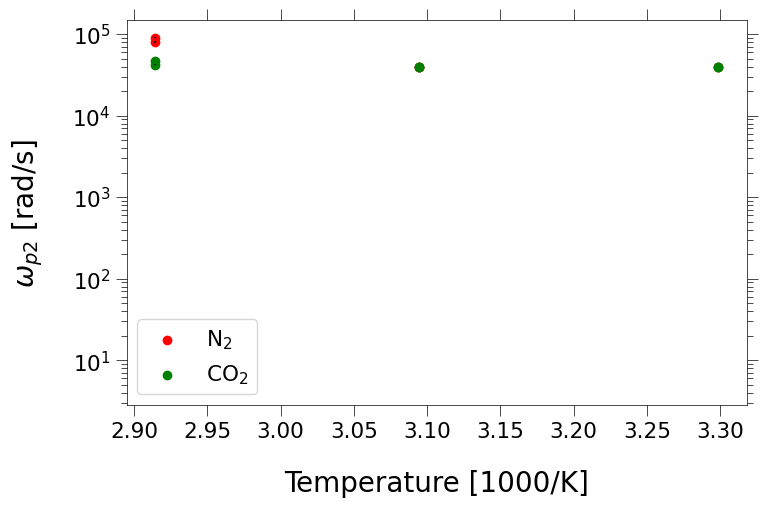

In [10]:
### plot final fit parameters against temperature
title = "Equilibrated fit parameter of " + SAMPLE
colors = ['red', 'green']

for i, p in enumerate(p_labels) :

    plt.yscale('log')

    for g_i, gas in enumerate(GASES) :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue

            x = P_ALL_[j][i][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        T = 1000/(v[0]+273.15)
        plt.scatter(T, v[1], linewidths=2, label=gas, color=colors[g_i])
        plt.errorbar(T, v[1], yerr=v[2:], fmt='none')
        plt.xlabel("Temperature [1000/K]")#"$1/(\\epsilon_0 k_B T)$")

    #plt.title(title)
    plt.ylabel(p)
    plt.legend()
    #plt.savefig(results_folder + "/endval/"+p_file_labels[i]+".pdf", bbox_inches='tight')
    plt.show()
